In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import fiona

In [2]:
gdb_path = '../data/raw/map_files/KEN_AdminBoundaries_working.gdb'

layer_names = ['adminUnitLookup', 'kenya_counties', 'kenya', 'admbndlALL', 'kenya_sub_counties', 'admbndpALL']
layers = dict(zip(fiona.listlayers(gdb_path), layer_names))

for i in ['adminUnitLookup', 'admbndlALL', 'admbndpALL']:
    
    layers.pop(i)

geo_dfs = dict()

for layer, name in layers.items():
    geo_dfs[name] = gpd.read_file(gdb_path, layer=layer)

geo_dfs['kenya_wards'] = gpd.read_file('../data/raw/map_files/Kenya_Wards/kenya_wards.shp')


def filter_geodf(geodf, admin_level, admin_names):
    return geodf[geodf[admin_level].str.contains('|'.join(admin_names if isinstance(admin_names, list) else [admin_names]))]

geo_dfs['narig_wards'] = filter_geodf(geo_dfs['kenya_wards'], 'ward', ['Kako', 'Mtito Andei', 'Tulimani', 'Thange'])

col_names = {'admin0Name_en': 'country',
             'admin1Name_en': 'county',
             'admin2Name_en': 'sub_county',
             'Shape_Length': 'perimeter',
             'Shape_Area': 'area',
             'subcounty': 'sub_county'}

for df in geo_dfs.values():
    df.rename(columns=col_names, inplace=True)

cols = ['country', 'county', 'sub_county', 'ward', 'perimeter', 'area', 'geometry']

for k, v in geo_dfs.items():
    v.drop(columns=[col for col in v.columns if col not in cols], inplace=True)
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].str.title().str.replace(' Sub County', '').str.replace(' Ward', '')
    v.to_file('../data/processed/geojson/{}.geojson'.format(k), driver='GeoJSON')

In [1]:
survey_path = '../data/raw/NARIG_Survey.xlsx'
column_names_path = '../data/processed/json/column_names.json'

survey_df = pd.read_excel(survey_path, usecols='A:EG')
col_names = json.load(open(column_names_path, 'r'))

survey_df.rename(columns=col_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               '6+': 6, 
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

ordinal_map = {'Strongly Agree': 5,
               'Agree': 4,
               'Neutral': 3,
               'Disagree': 2,
               'Strongly Disagree': 1}

survey_df.replace(replace_map, inplace=True)
survey_df.replace(ordinal_map, inplace=True)

survey_df['gender'] = survey_df['gender'].str.split().str[-1]
survey_df = survey_df.astype({'household_size': int})

survey_df['age'] = survey_df['age'].replace(0, np.nan)
# survey_df['household_size'] = survey_df['household_size'].replace(6, np.nan)

sample_size_pre = survey_df['value_chain'].value_counts().to_frame()

orig_col_order = list(survey_df.columns)

value_chains = list(survey_df['value_chain'].unique())

narig_dfs = {vc: survey_df[survey_df['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}


def engineer_change_features(dataframe):
    for col in dataframe.columns:
        if col.endswith('_before') or col.endswith('_after'):
            base_col = col.rsplit('_', 1)[0]
            before_col = base_col + '_before'
            after_col = base_col + '_after'
            if before_col in dataframe.columns and after_col in dataframe.columns:
                change_col = base_col + '_change'
                dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
                change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
                change_col_data = dataframe[change_col]
                dataframe.drop(columns=[change_col], inplace=True)
                dataframe.insert(change_col_index, change_col, change_col_data)
    return dataframe

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    
    for col in v.select_dtypes('number').columns:
        if v[col].skew() > 0:
            v[col] = v[col].mask(v[col] > v[col].quantile(0.99))
        elif v[col].skew() < 0:
            v[col] = v[col].mask(v[col] < v[col].quantile(0.01))
    
    v.dropna(axis=0, inplace=True)

    v = engineer_change_features(v)
    
narig_dfs['Survey data'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['Survey data'] = narig_dfs['Survey data'][[col for col in orig_col_order if col in narig_dfs['Survey data'].columns]]

narig_dfs['Survey data'] = engineer_change_features(narig_dfs['Survey data'])

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    display(k)
    display(v.info(), v.head())
    
    v.to_csv('../data/processed/csv/cleaned/{}.csv'.format(k.replace(' ', '_').lower()), index=False)

sample_size_post = narig_dfs['Survey data']['value_chain'].value_counts().to_frame()

sample_size = pd.concat([sample_size_pre, sample_size_post], axis=1)
sample_size.columns = ['preprocessing', 'postprocessing']
sample_size.loc['Survey data'] = sample_size.sum()
sample_size['pre_post_ratio'] = sample_size['postprocessing'] / sample_size['preprocessing']

display(sample_size)

NameError: name 'pd' is not defined

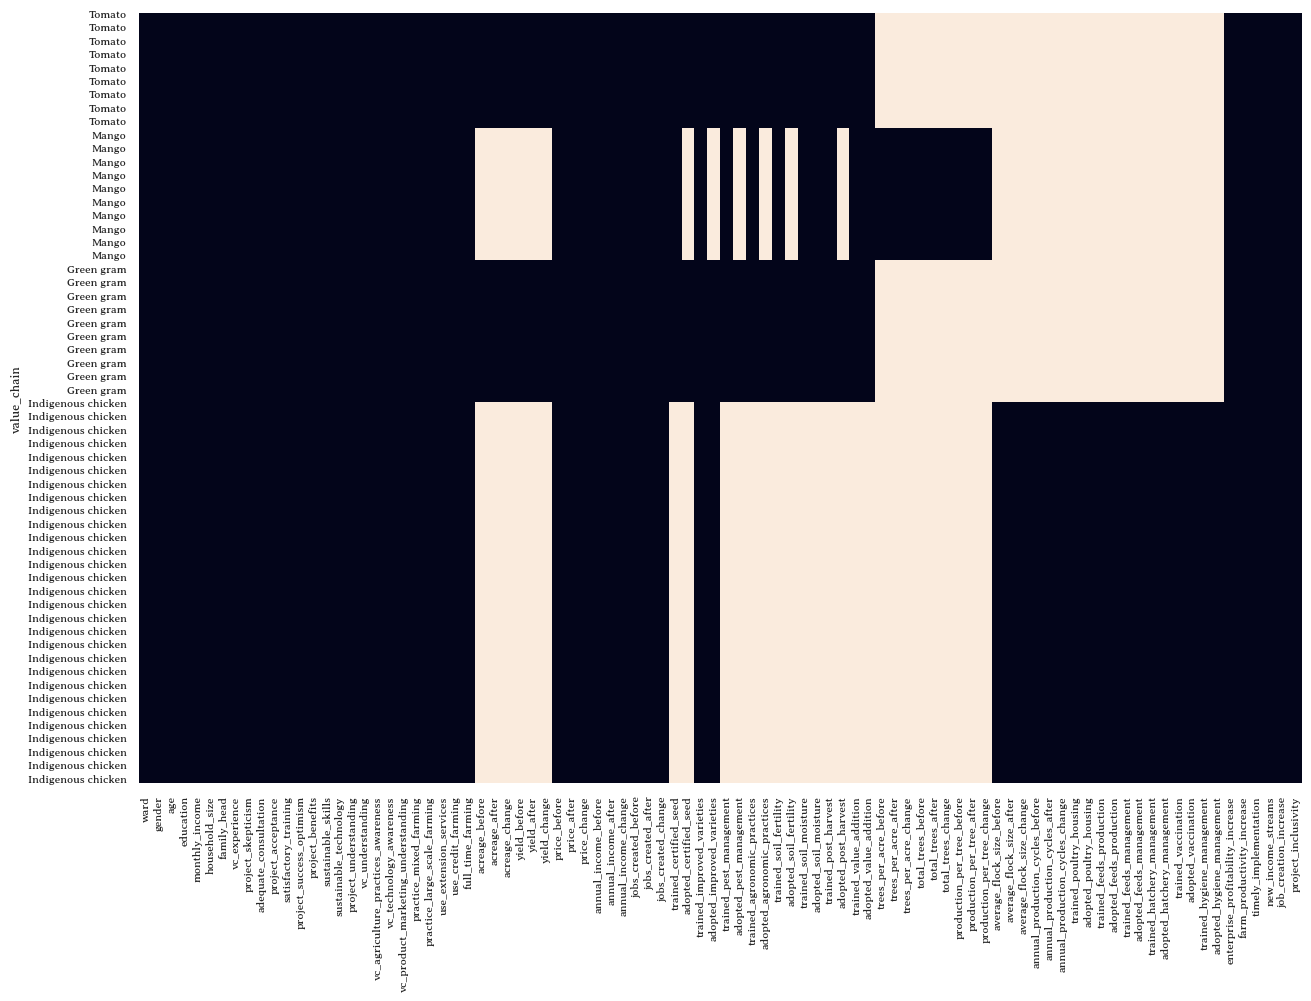

In [81]:
plt.figure(figsize=(15, 10))
sns.heatmap(narig_dfs['Survey data'].set_index('value_chain').isnull(), cbar=False)
plt.show()

In [82]:
narig_gpd = geo_dfs['narig_wards'].merge(narig_dfs['Survey data'], on='ward', how='right')

display(narig_gpd.info(), narig_gpd.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   county                              287 non-null    object  
 1   sub_county                          287 non-null    object  
 2   ward                                287 non-null    object  
 3   geometry                            287 non-null    geometry
 4   gender                              287 non-null    category
 5   age                                 287 non-null    float64 
 6   education                           287 non-null    category
 7   monthly_income                      287 non-null    float64 
 8   household_size                      287 non-null    float64 
 9   family_head                         287 non-null    category
 10  value_chain                         287 non-null    category
 11  vc_experience           

None

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,trained_vaccination,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67.0,Secondary,20000.0,4.0,Yes,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33.0,Primary,5000.0,3.0,No,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73.0,Primary,800.0,6.0,No,...,NaN,NaN,NaN,NaN,5.0,5.0,4.0,5.0,5.0,5.0
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71.0,Secondary,10000.0,5.0,Yes,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,50.0,Primary,20000.0,6.0,No,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0


In [83]:
for col in narig_gpd.select_dtypes('number').columns:
    if narig_gpd[col].skew() > 0:
        narig_gpd[col] = np.log1p(narig_gpd[col])
        # Rename column to indicate log transformation
        narig_gpd.rename(columns={col: col + '_log'}, inplace=True)

C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
# # Save to GeoJSON
# narig_gpd.to_file('../data/processed/geojson/narig_survey.geojson', driver='GeoJSON')

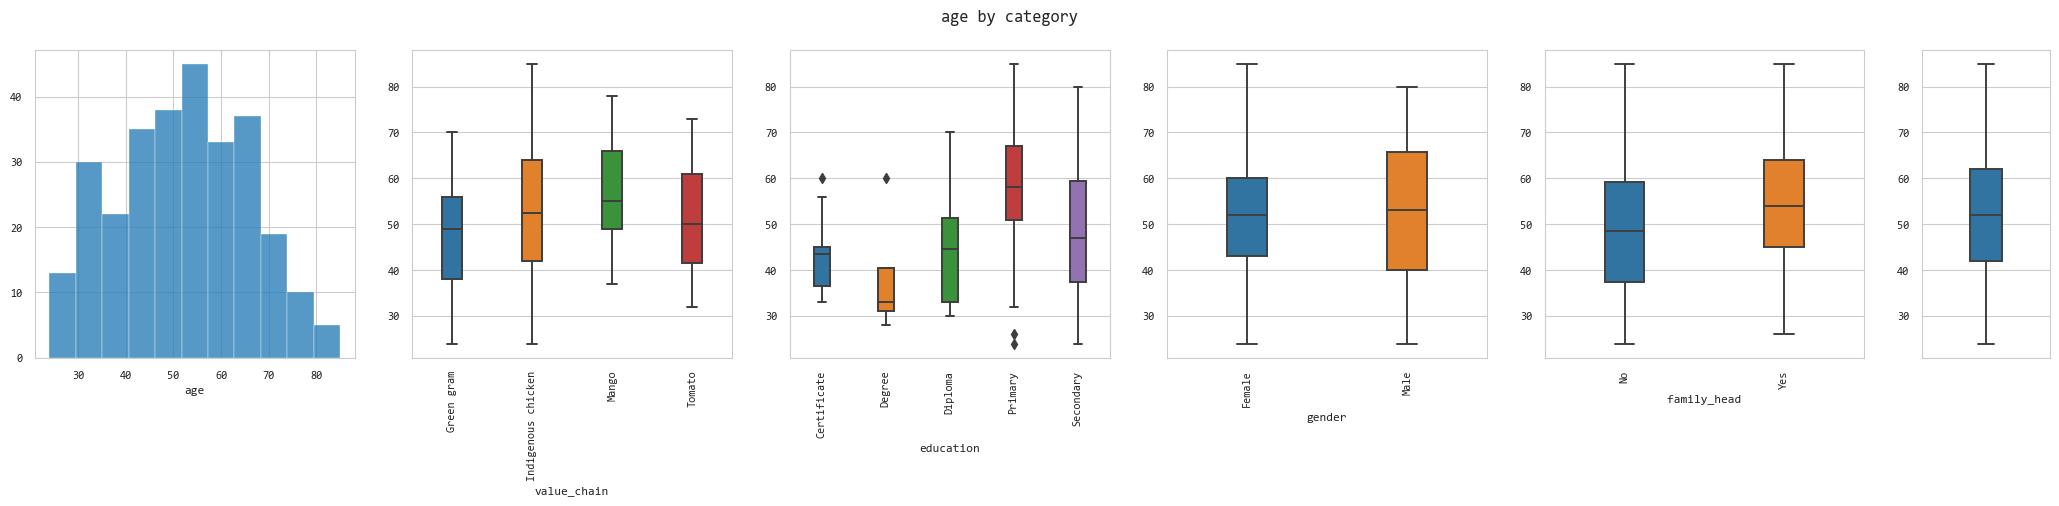

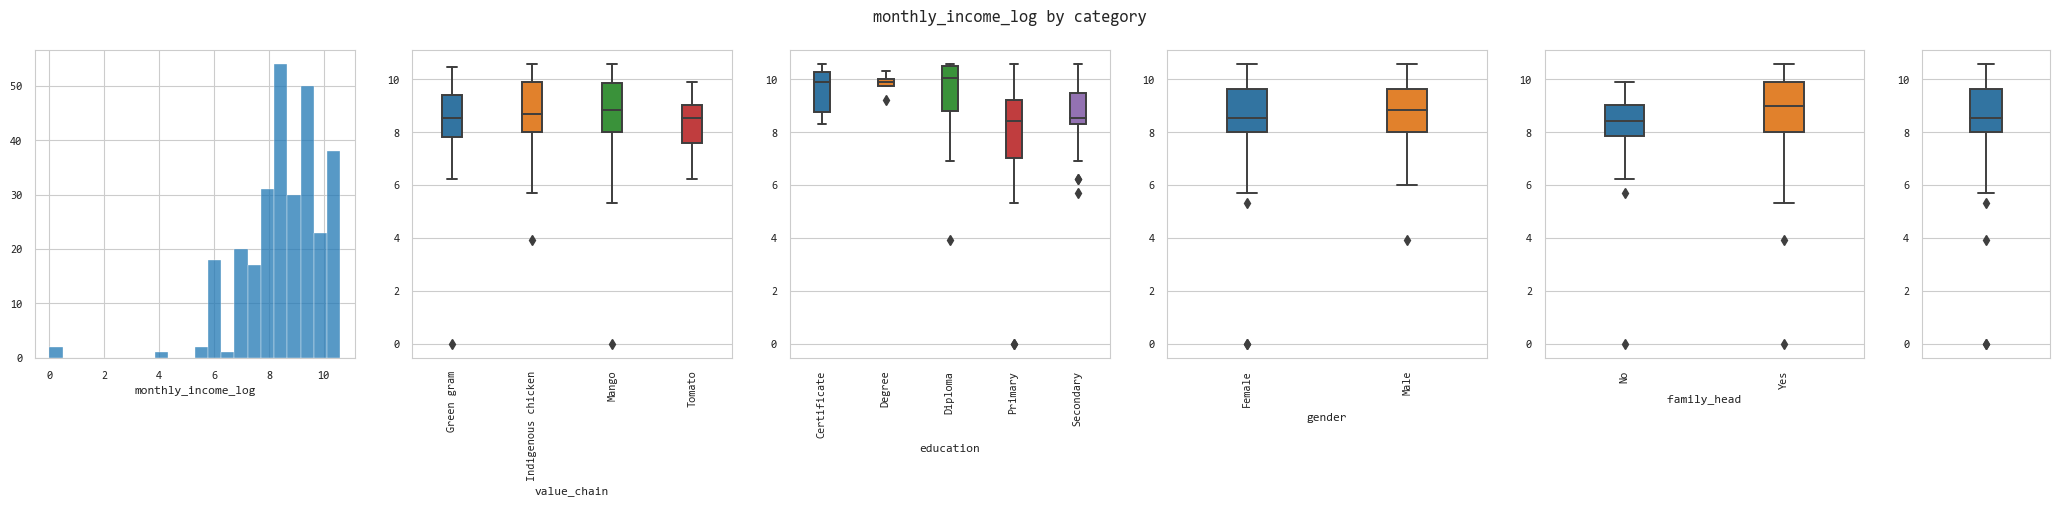

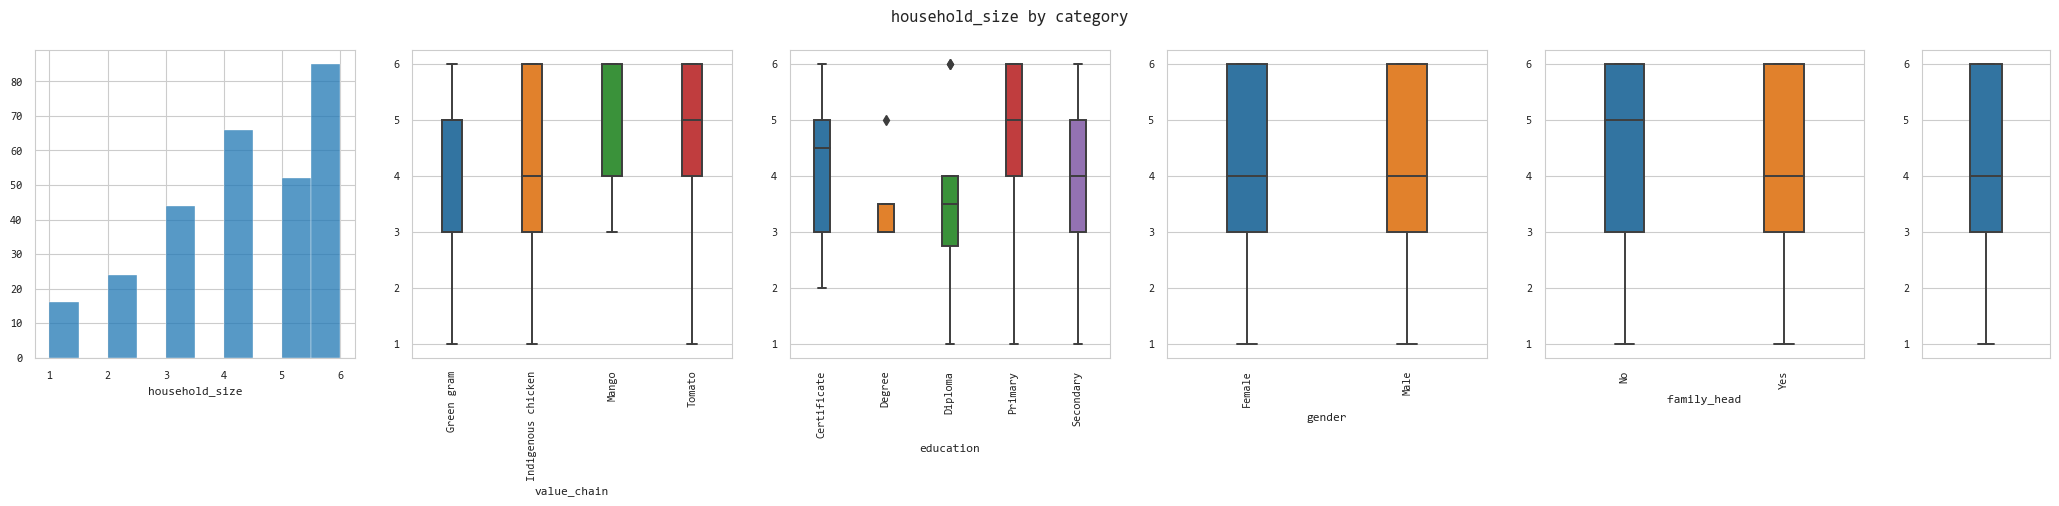

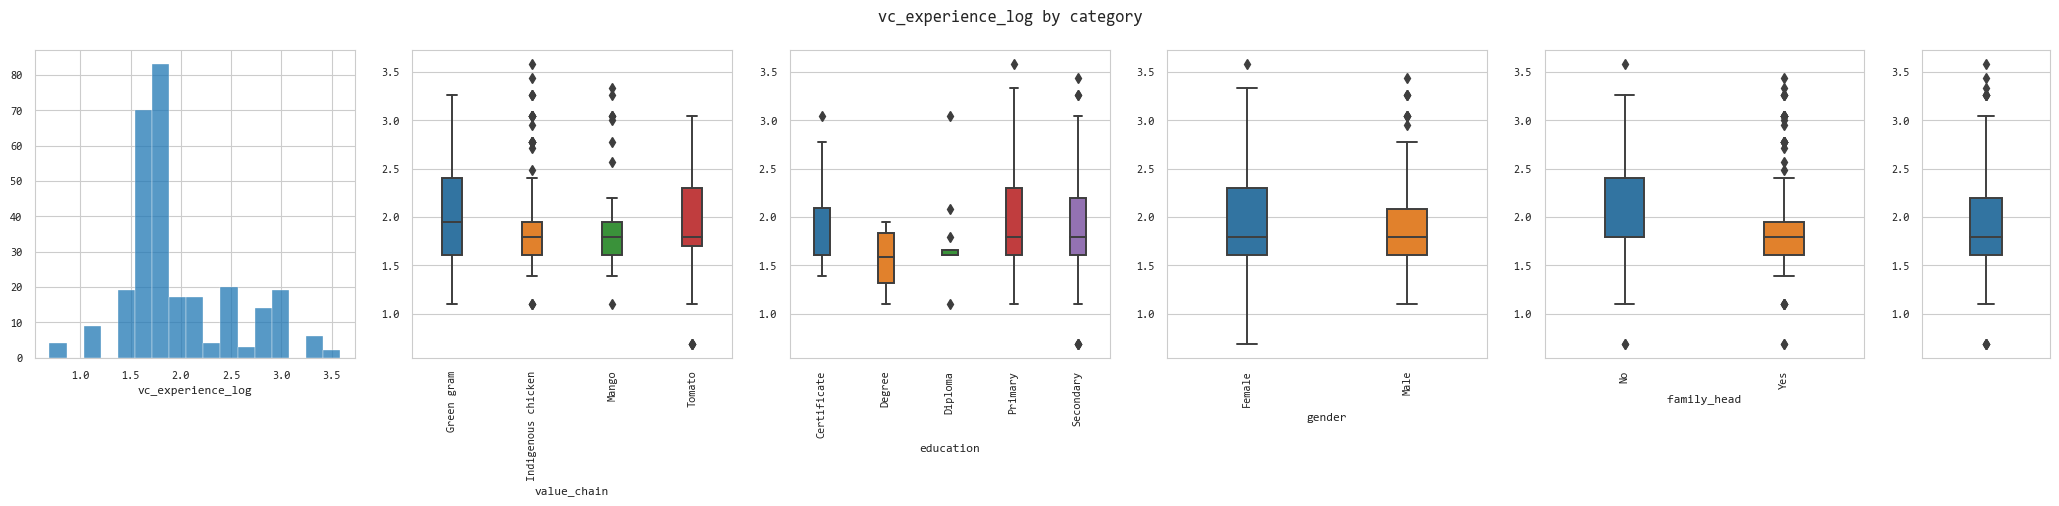

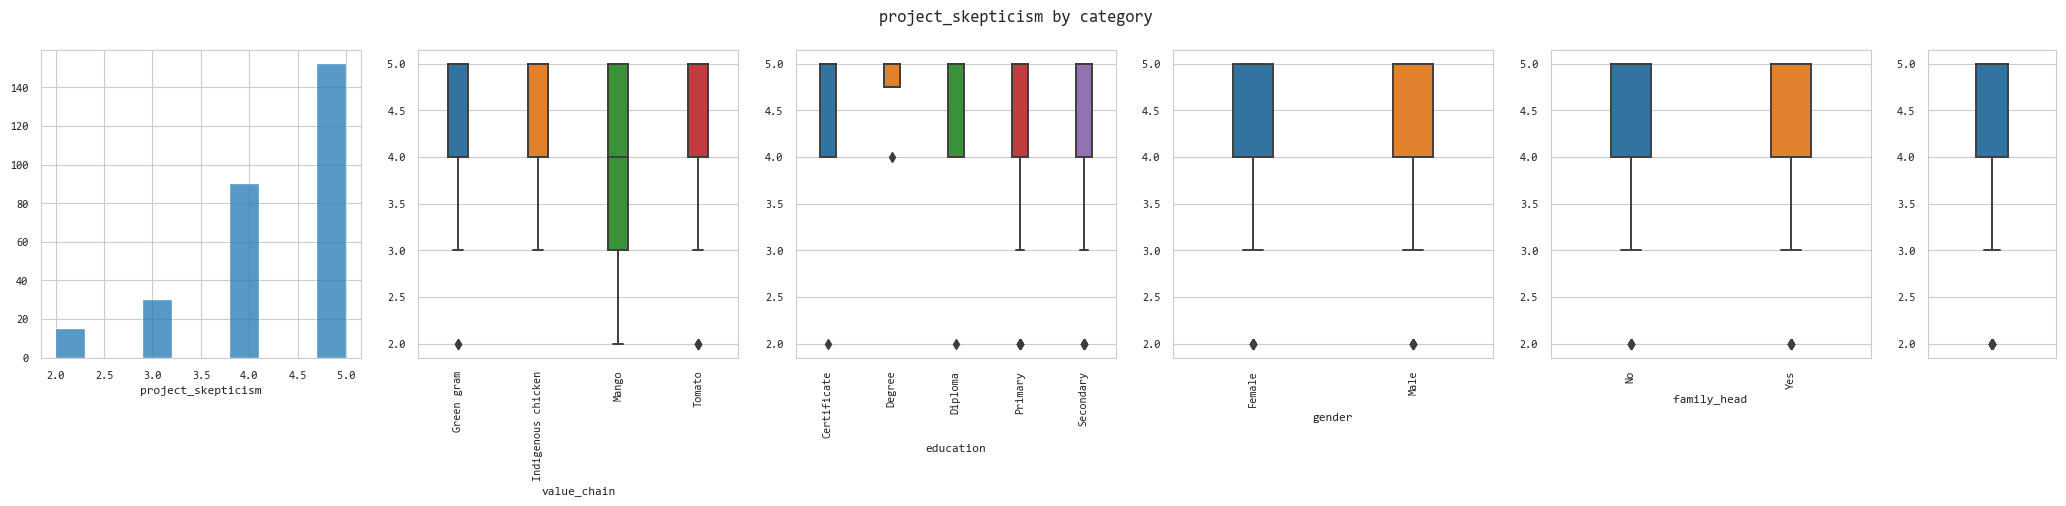

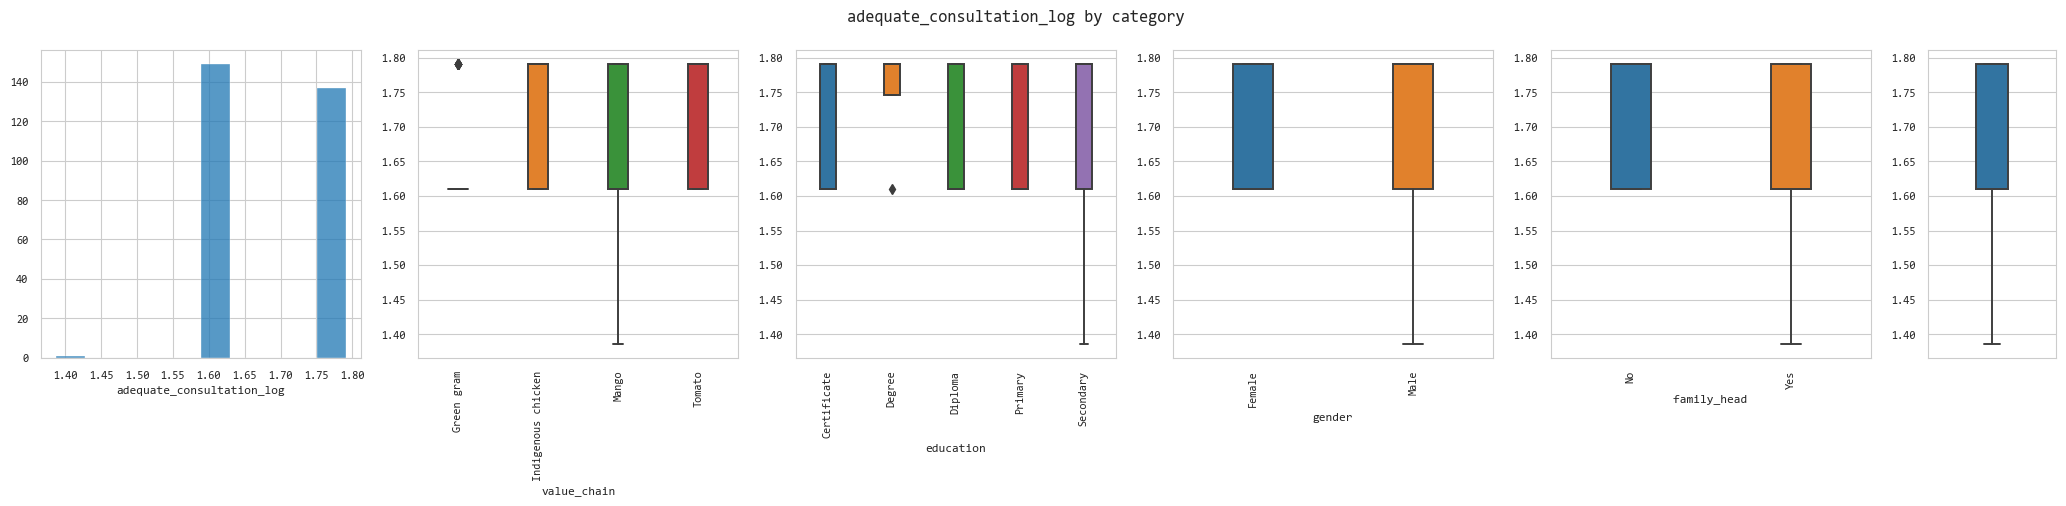

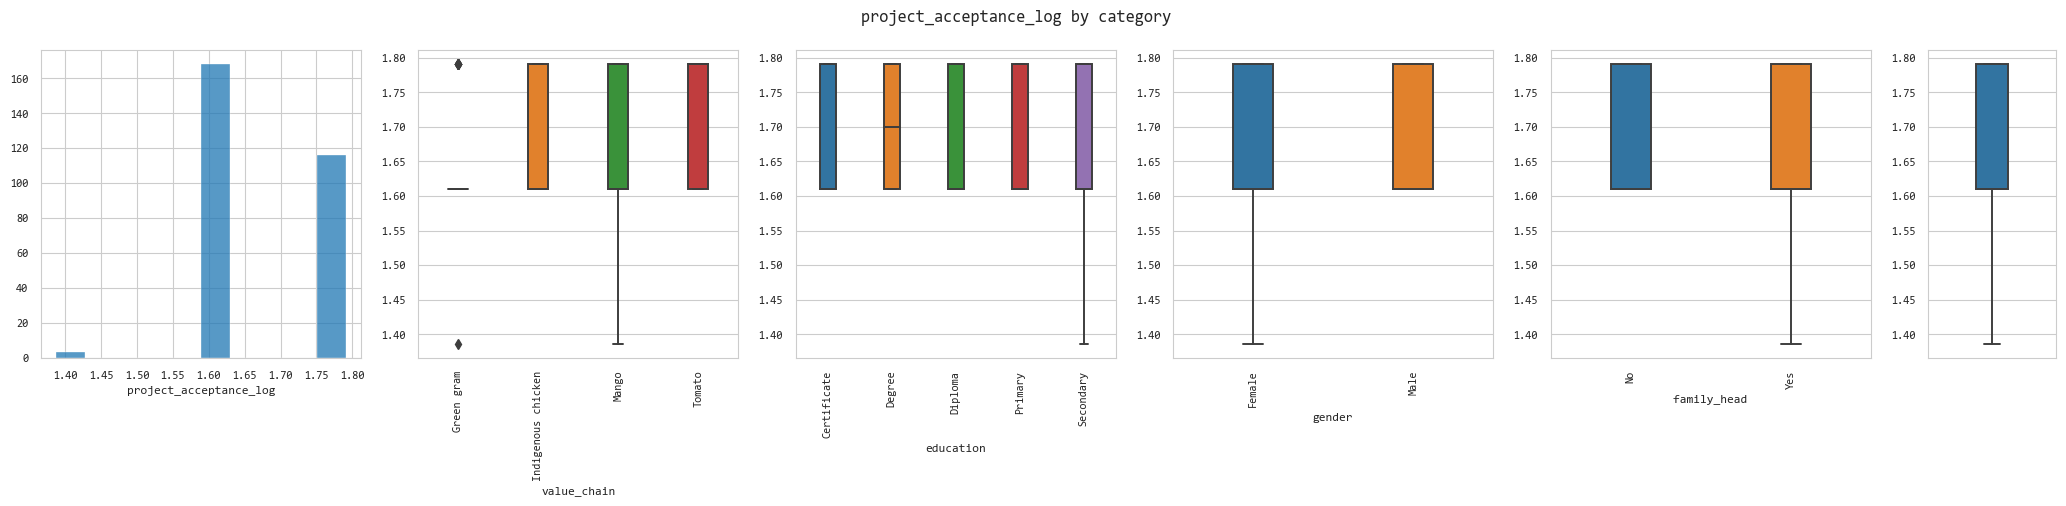

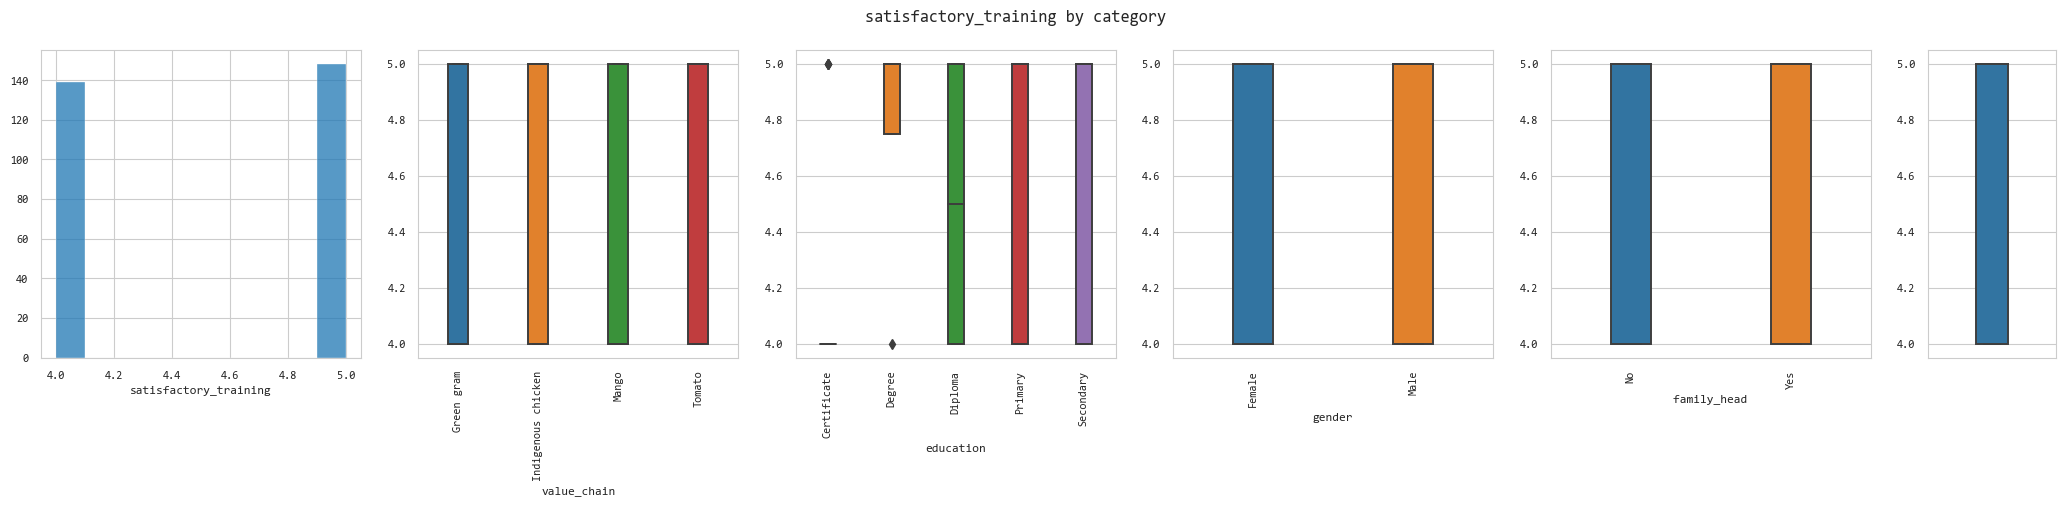

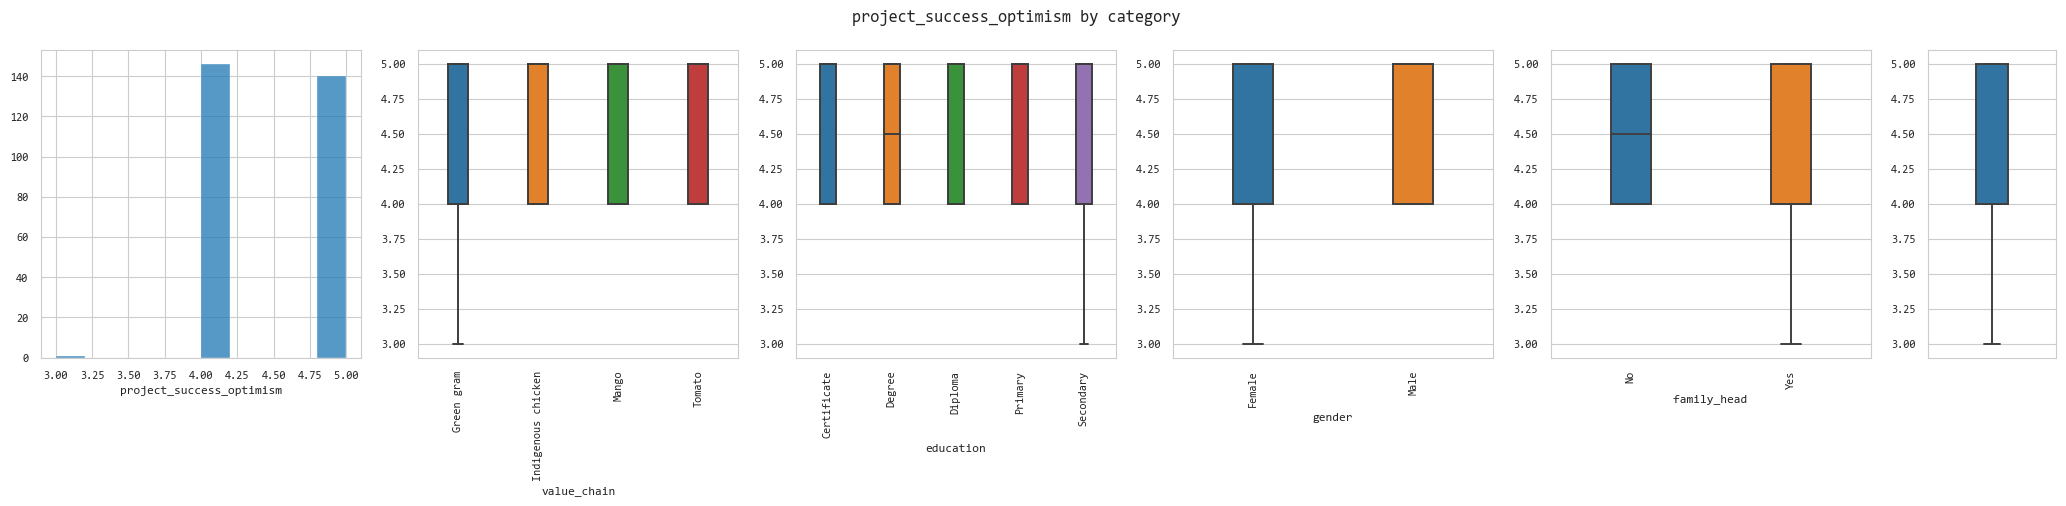

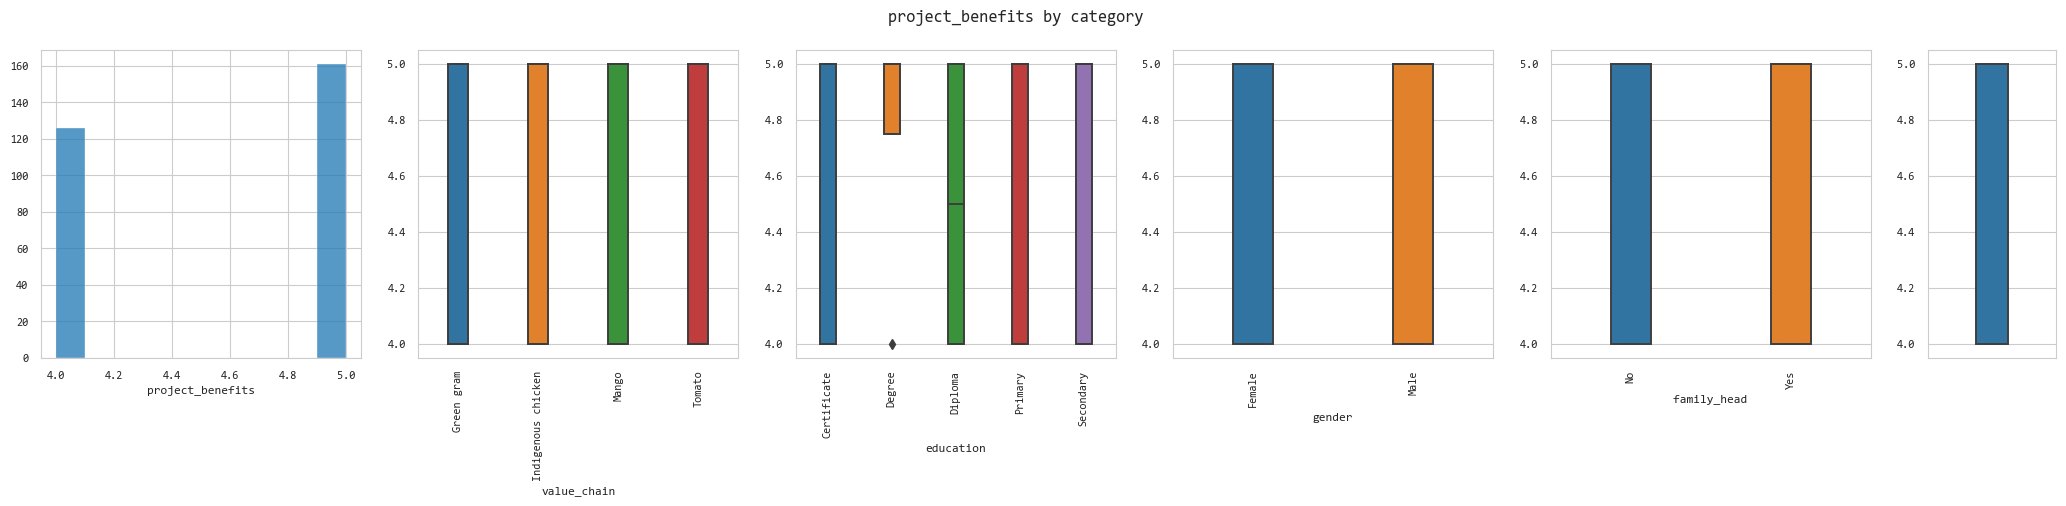

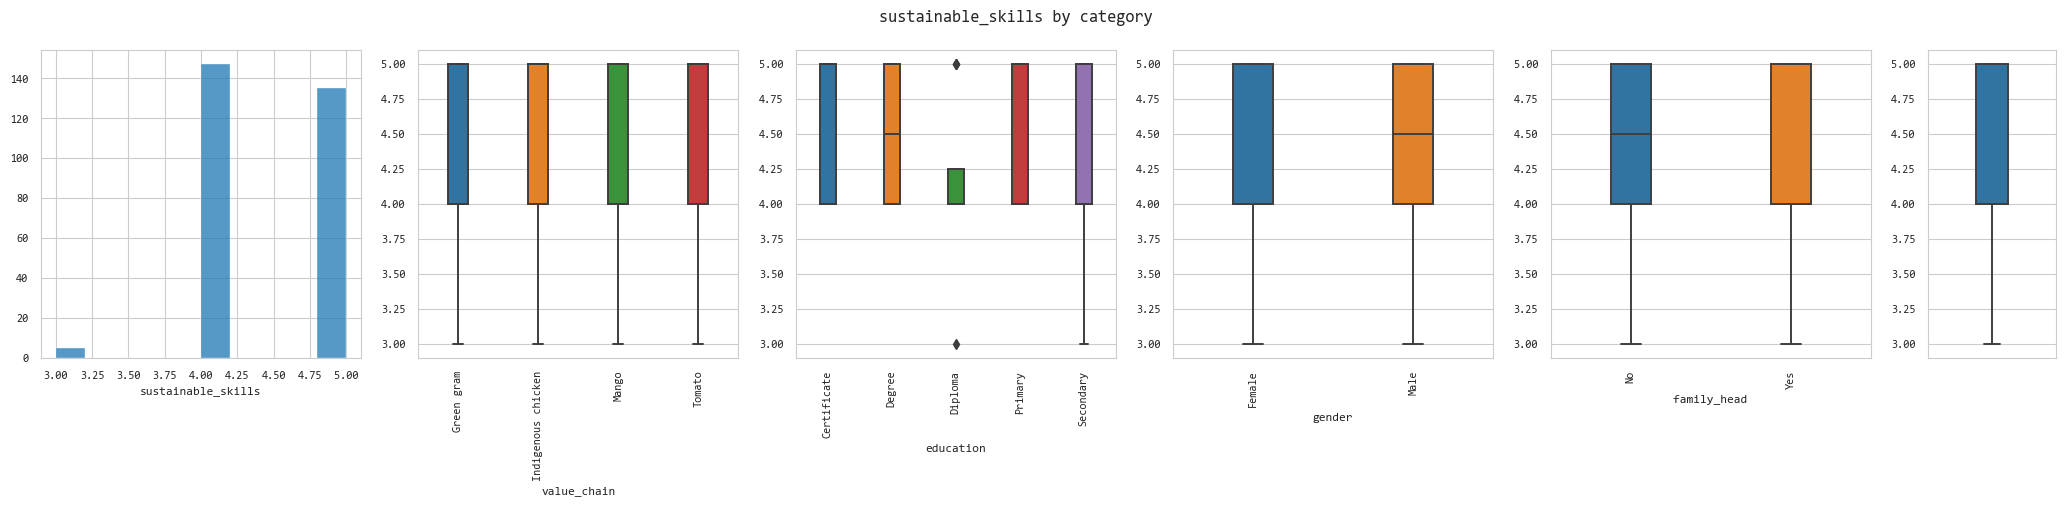

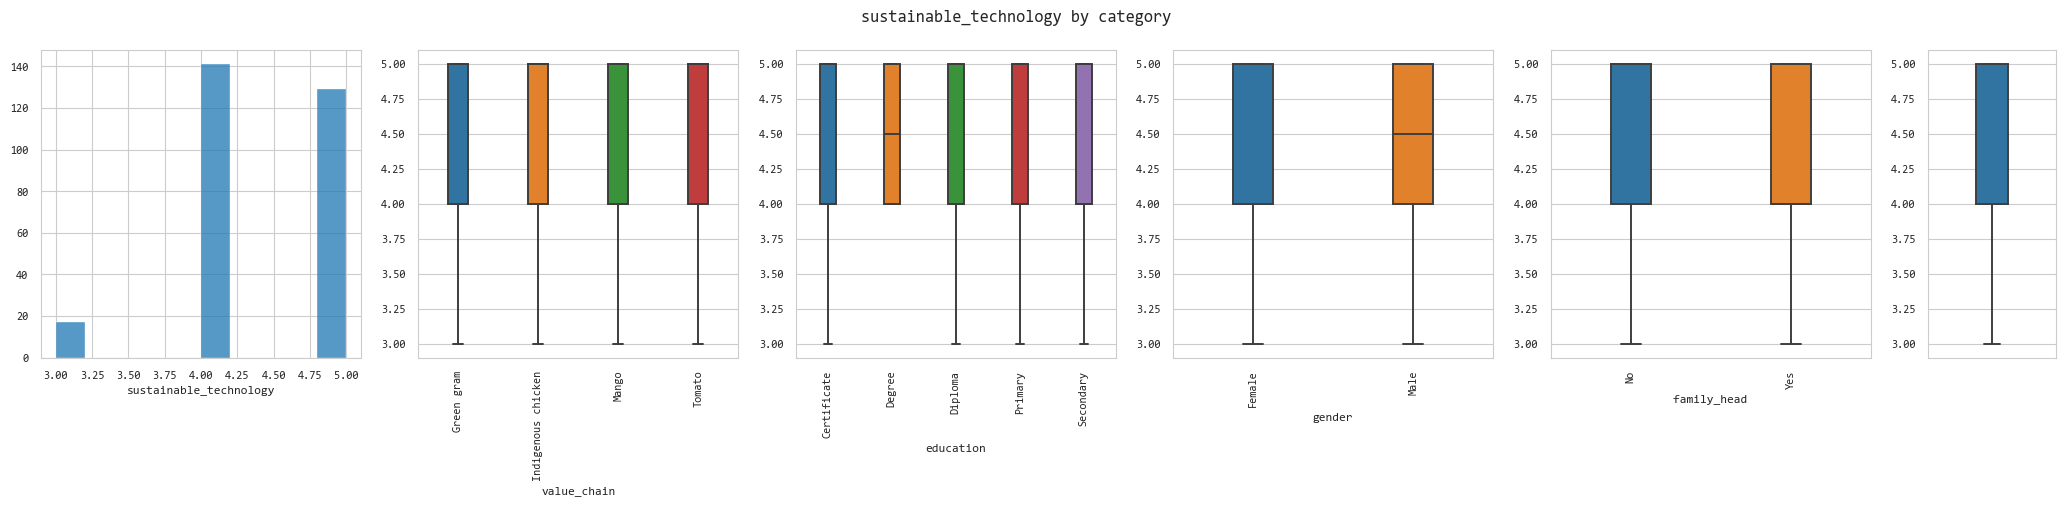

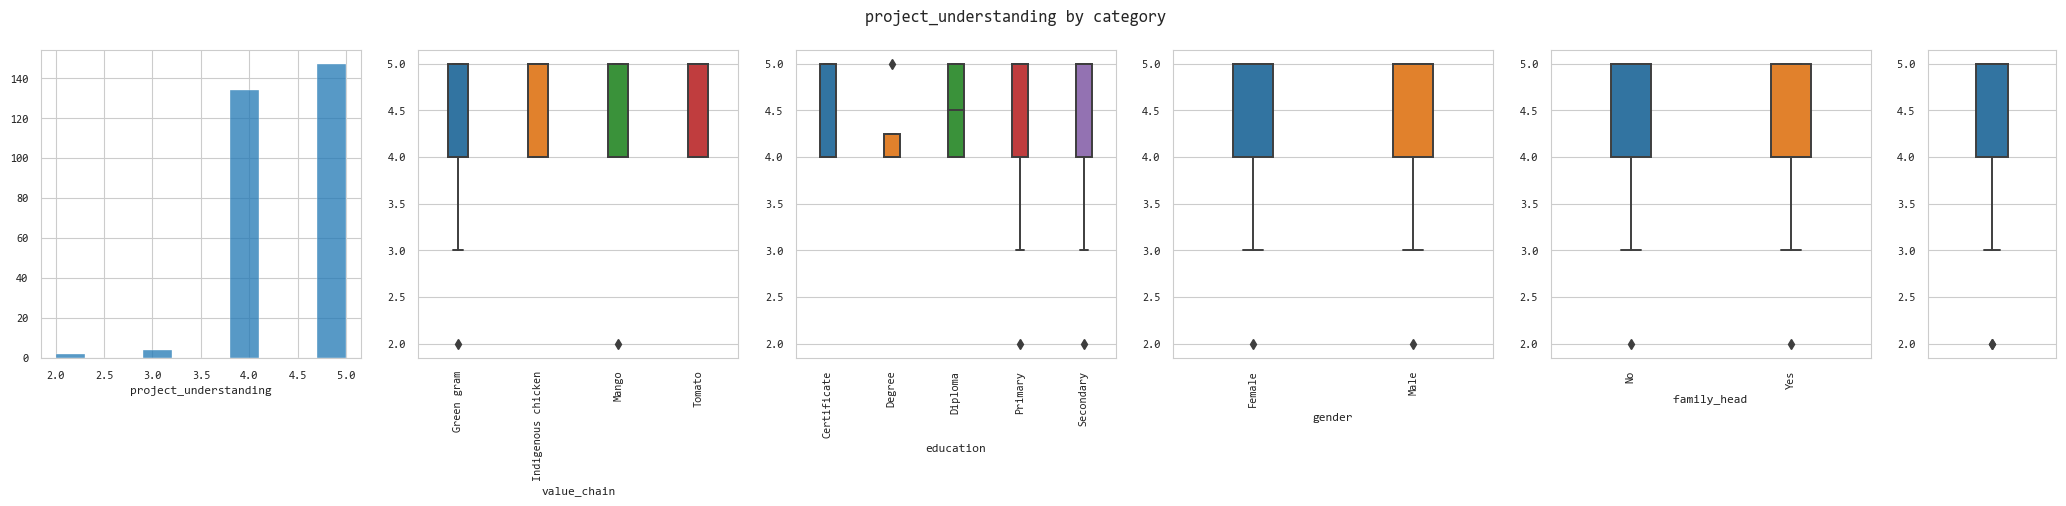

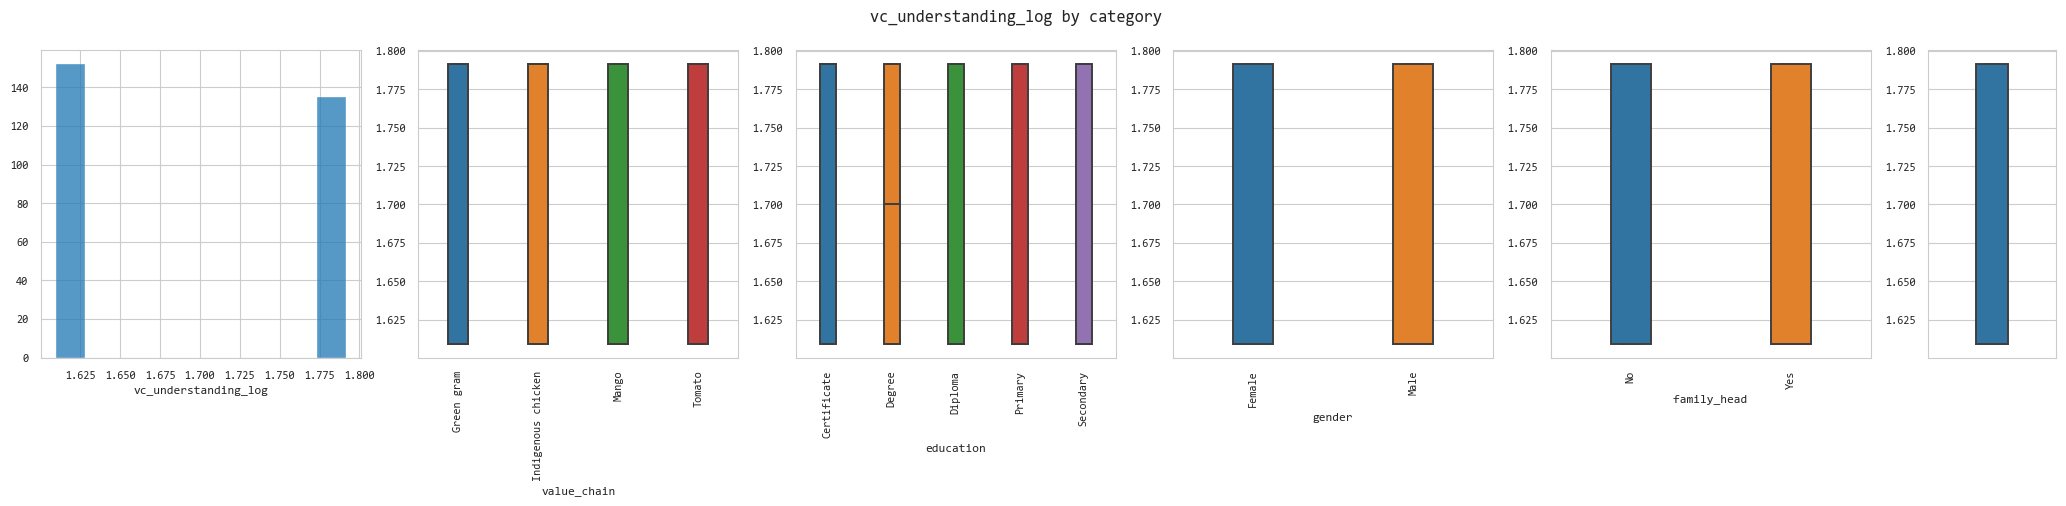

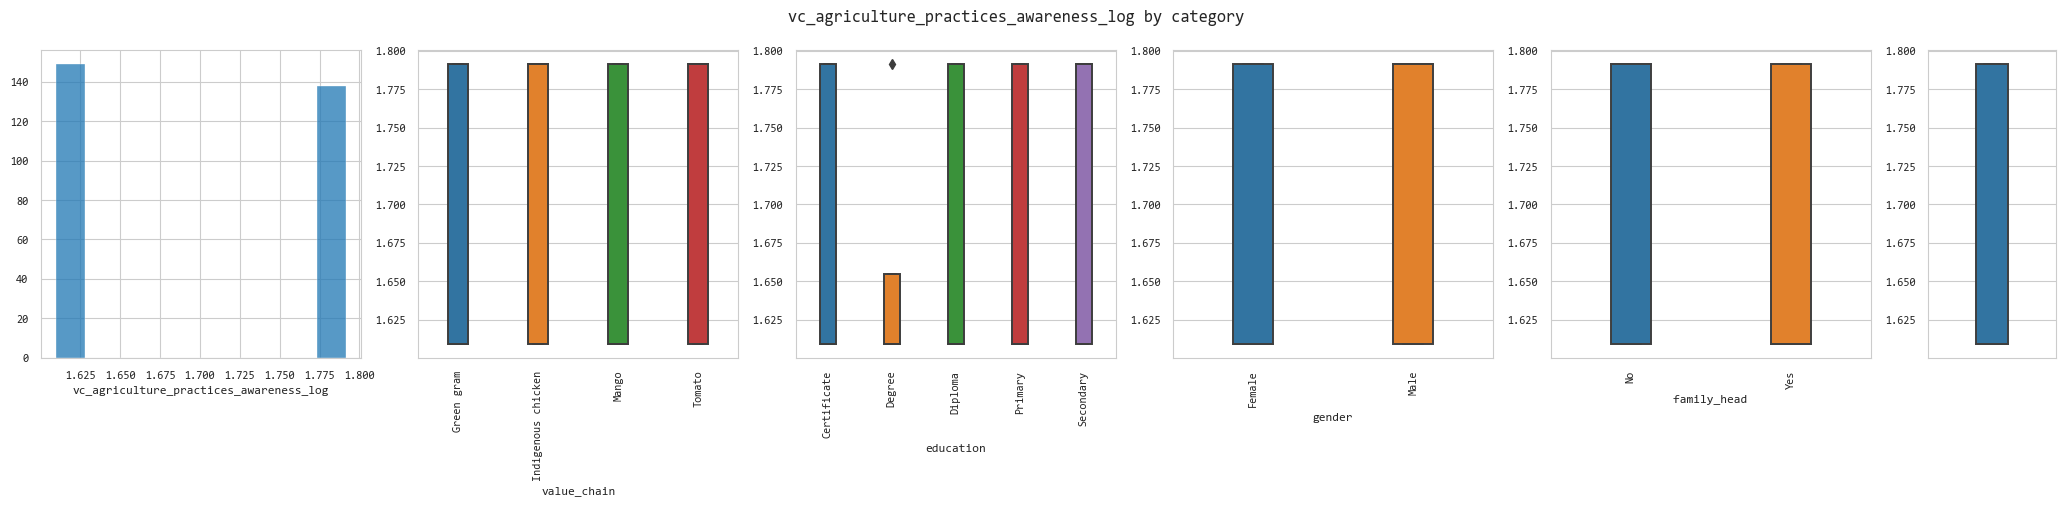

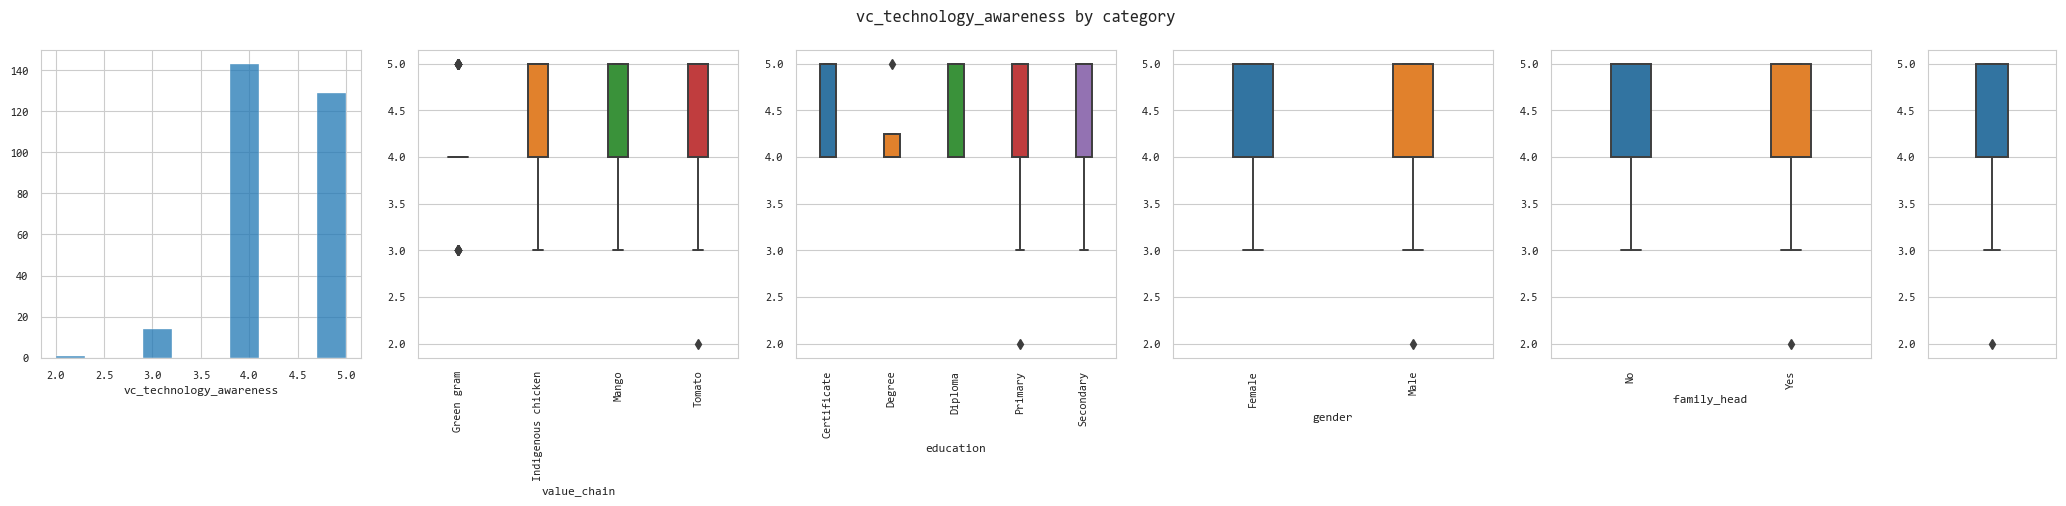

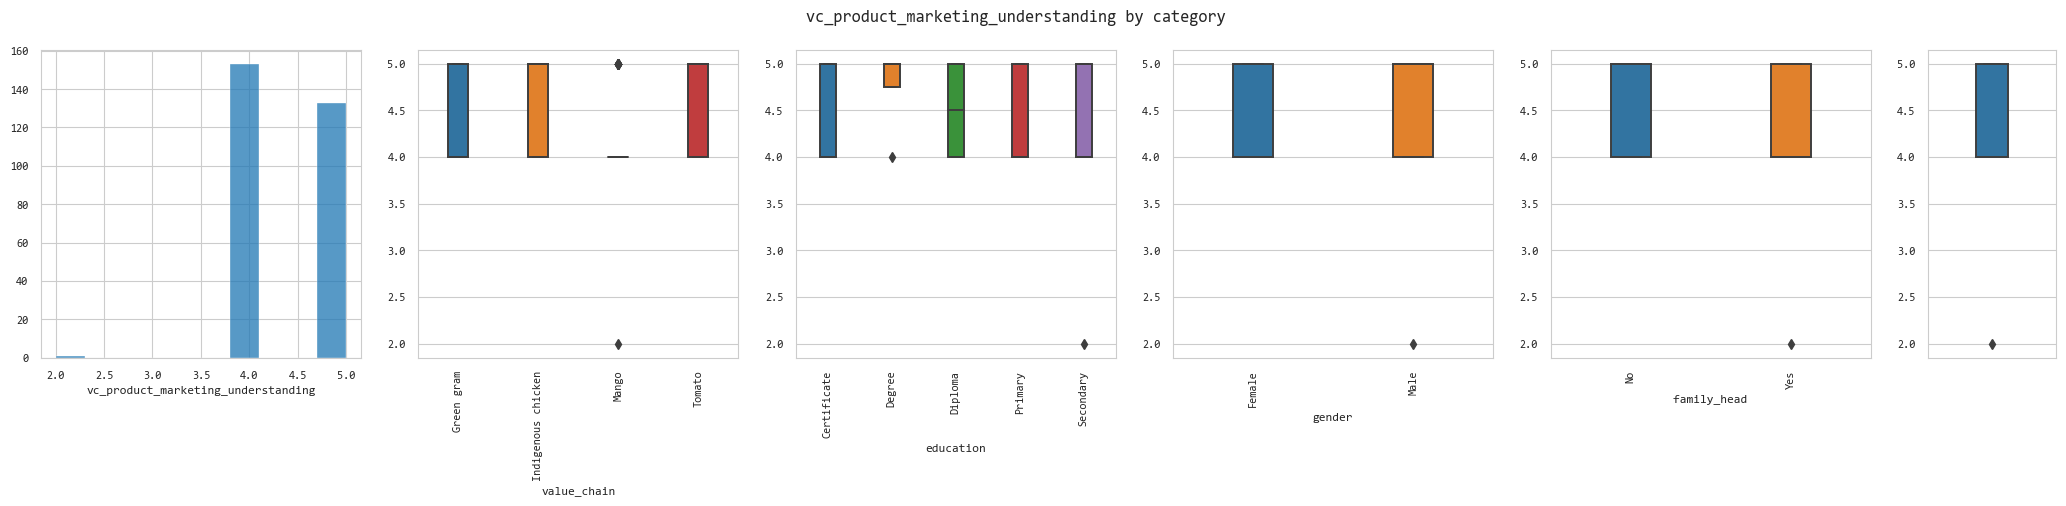

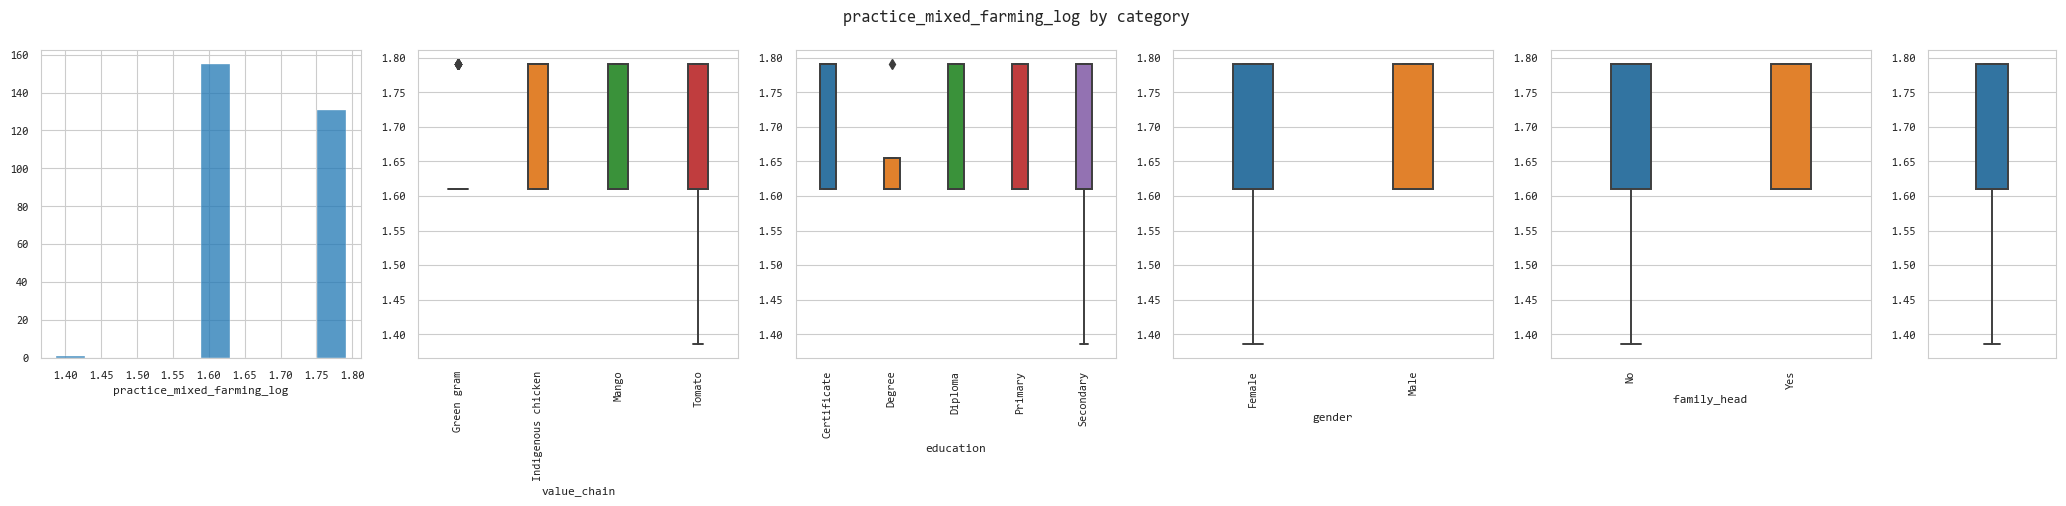

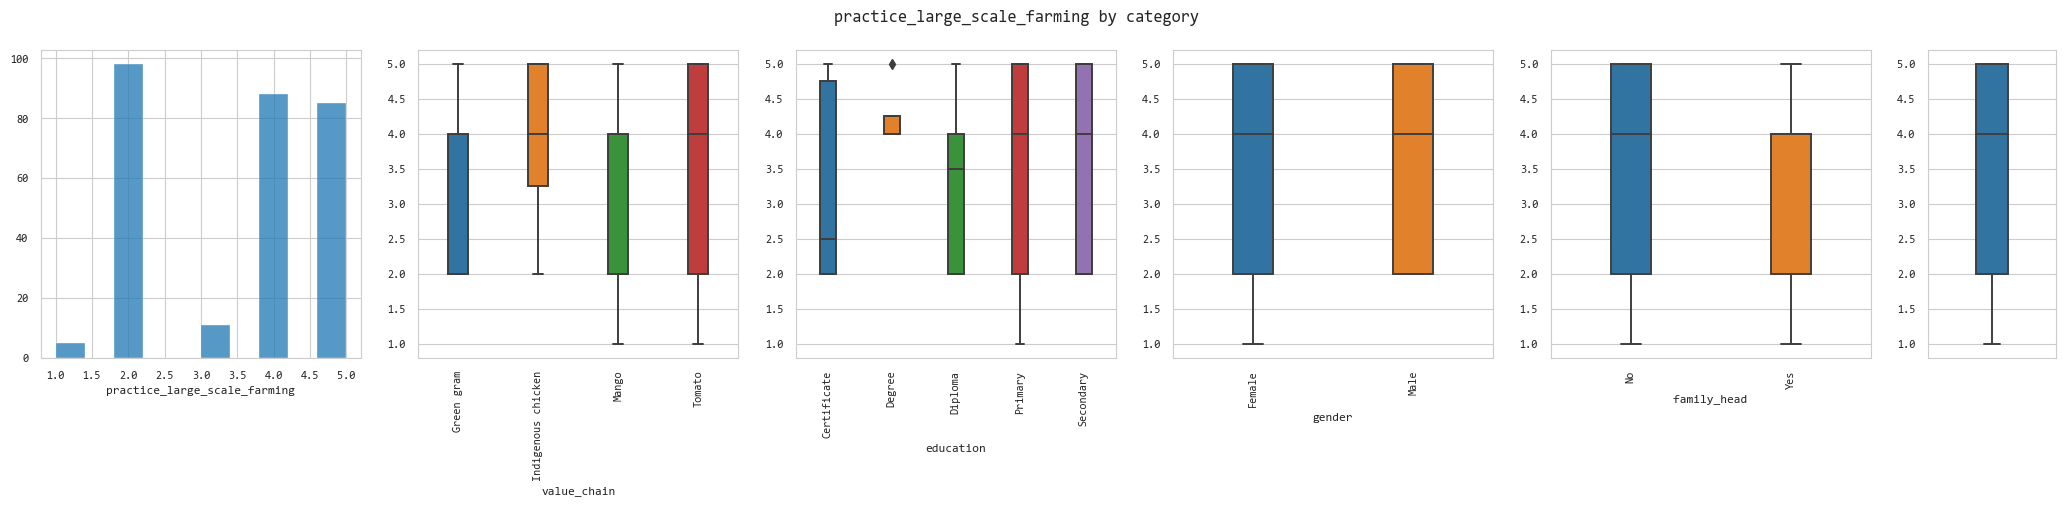

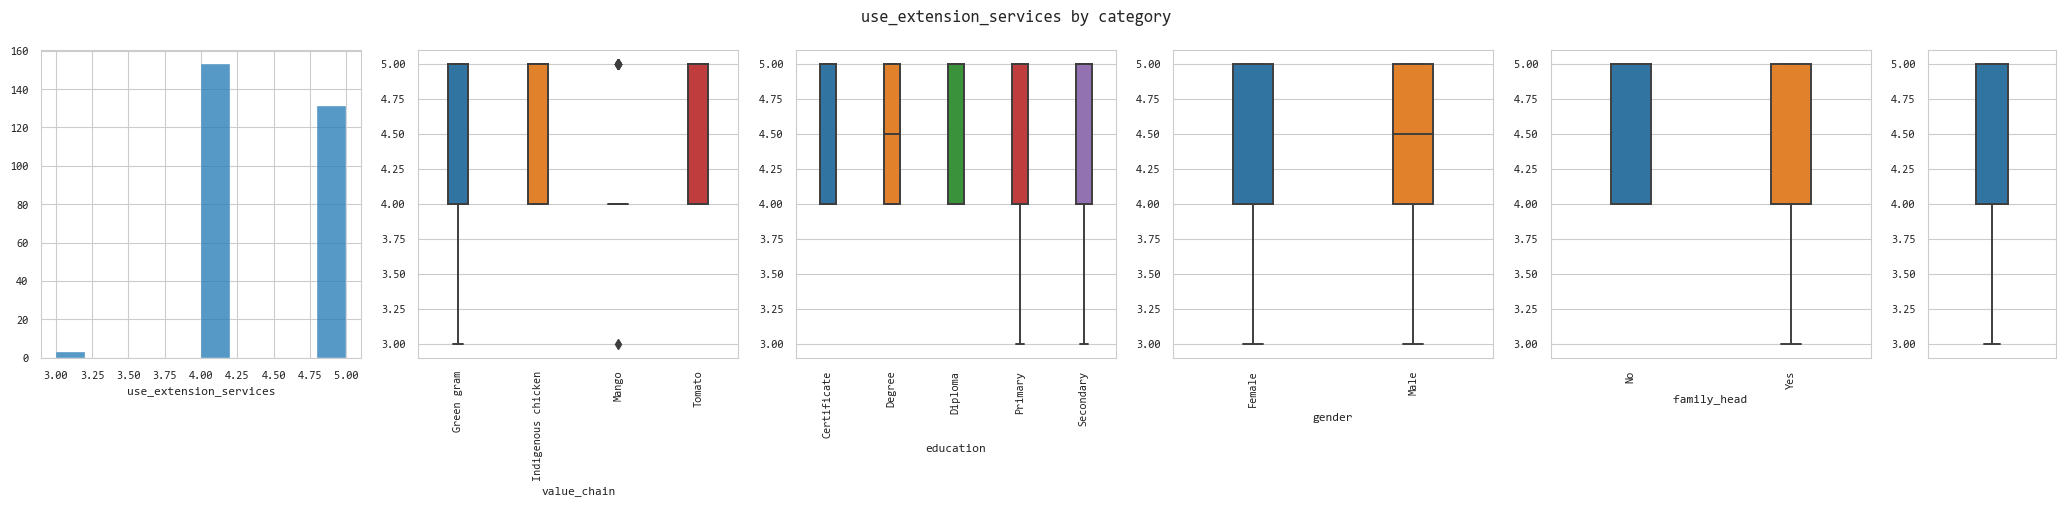

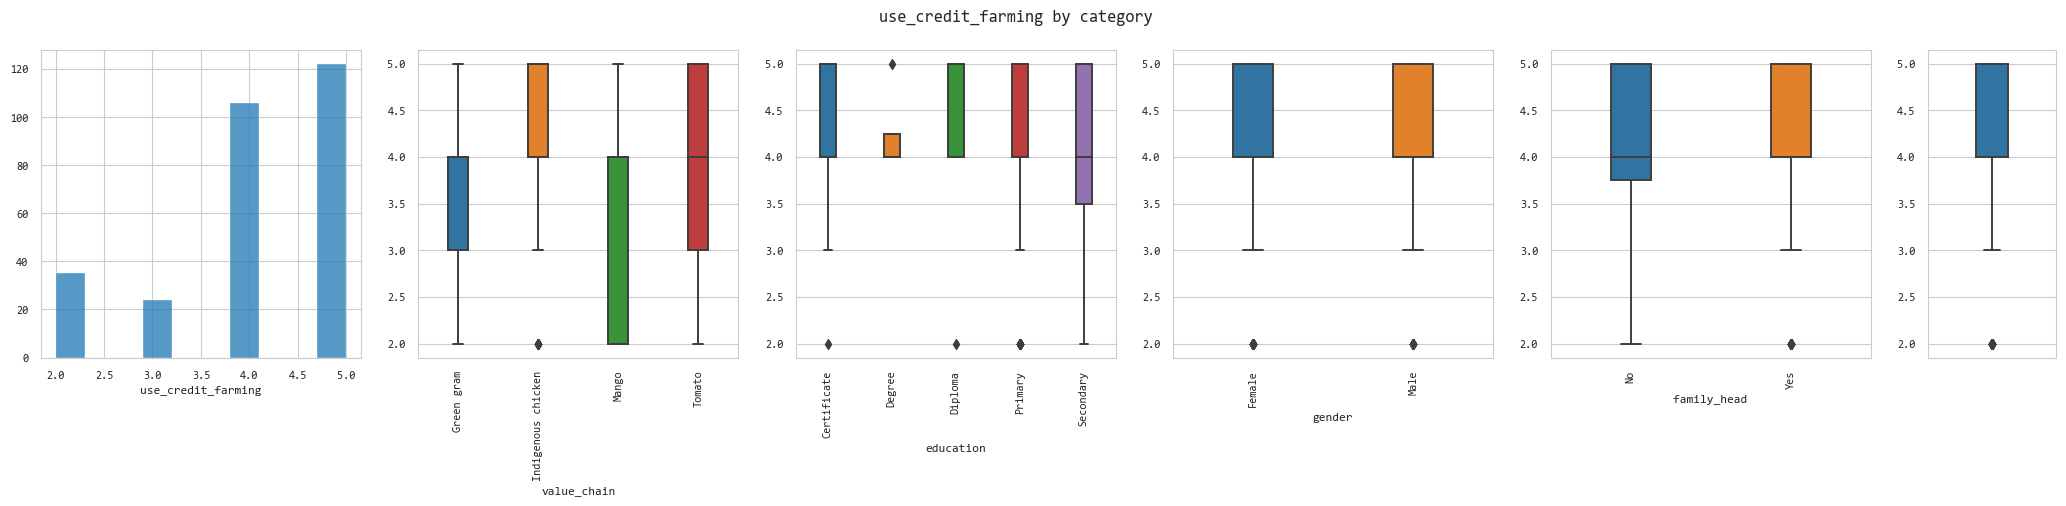

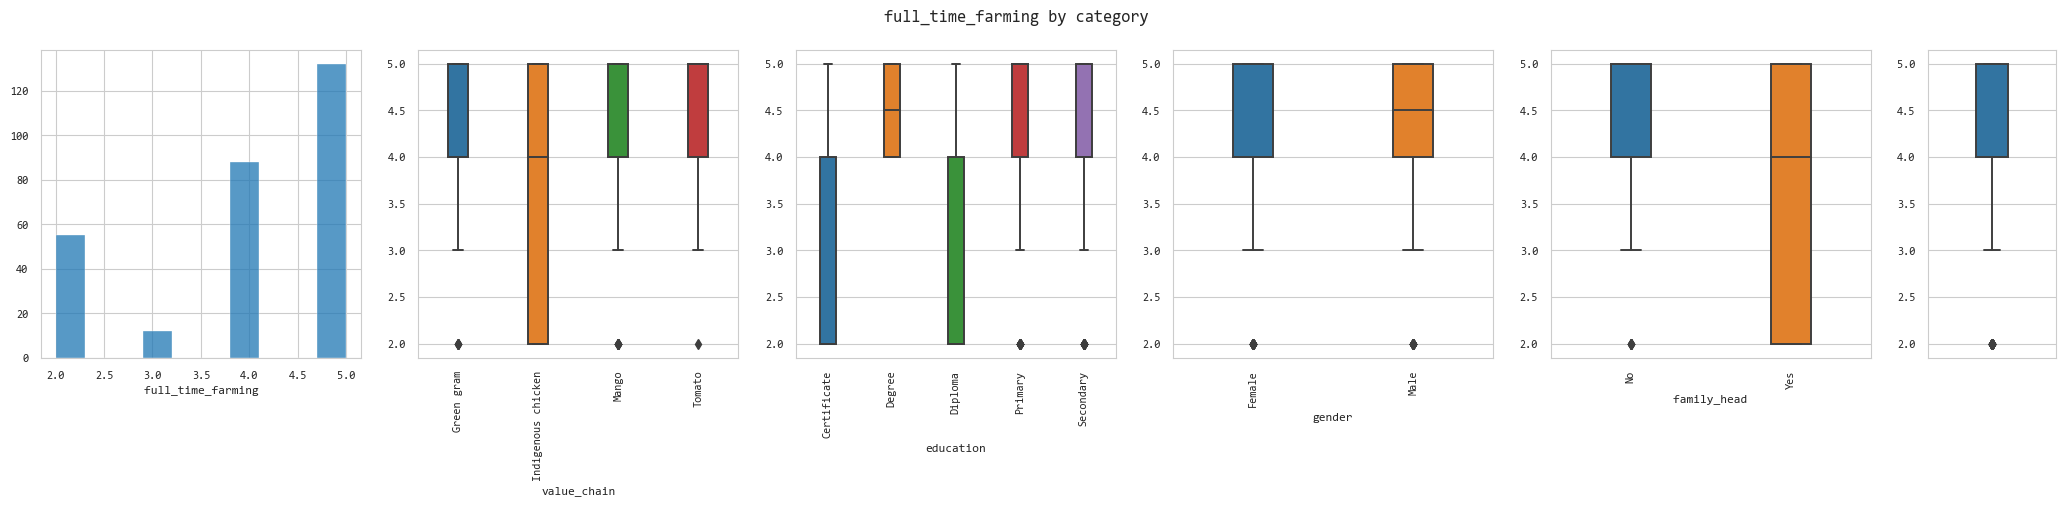

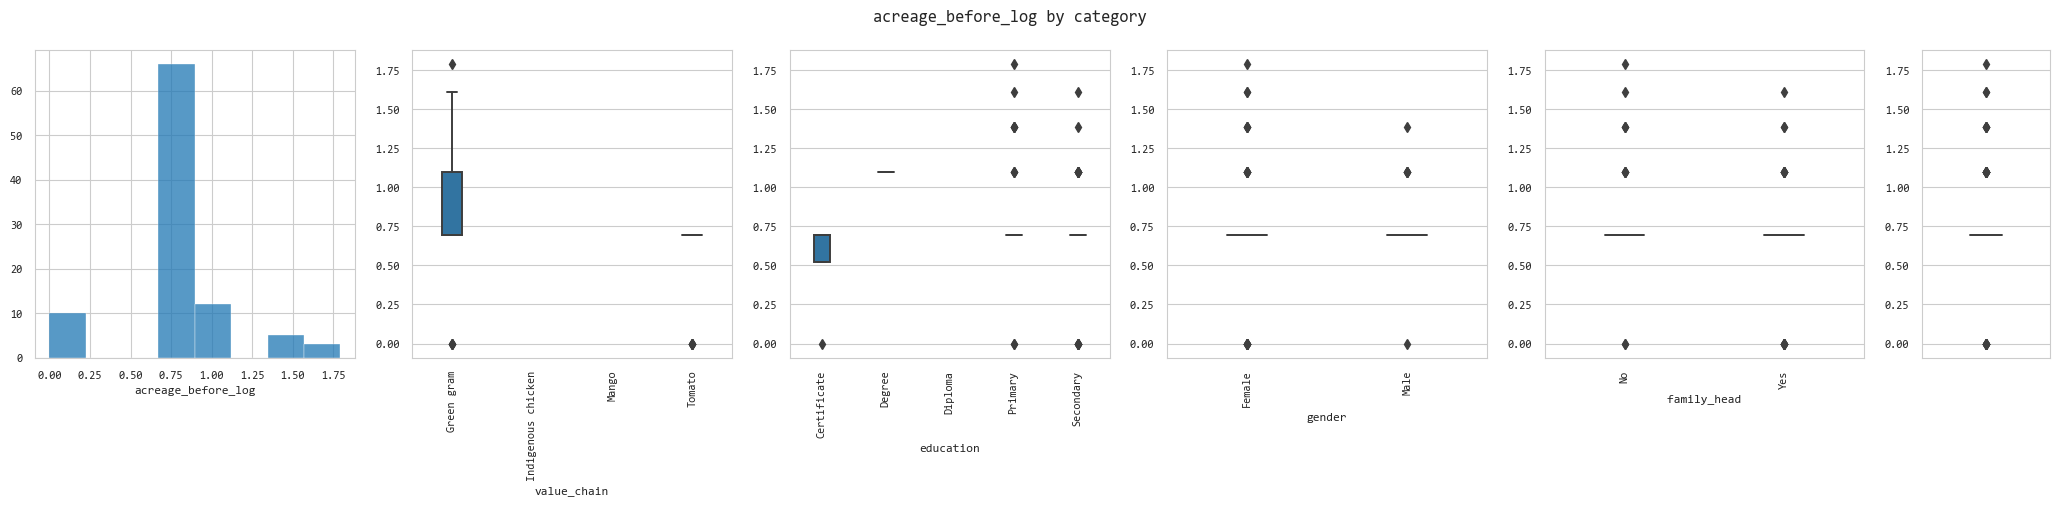

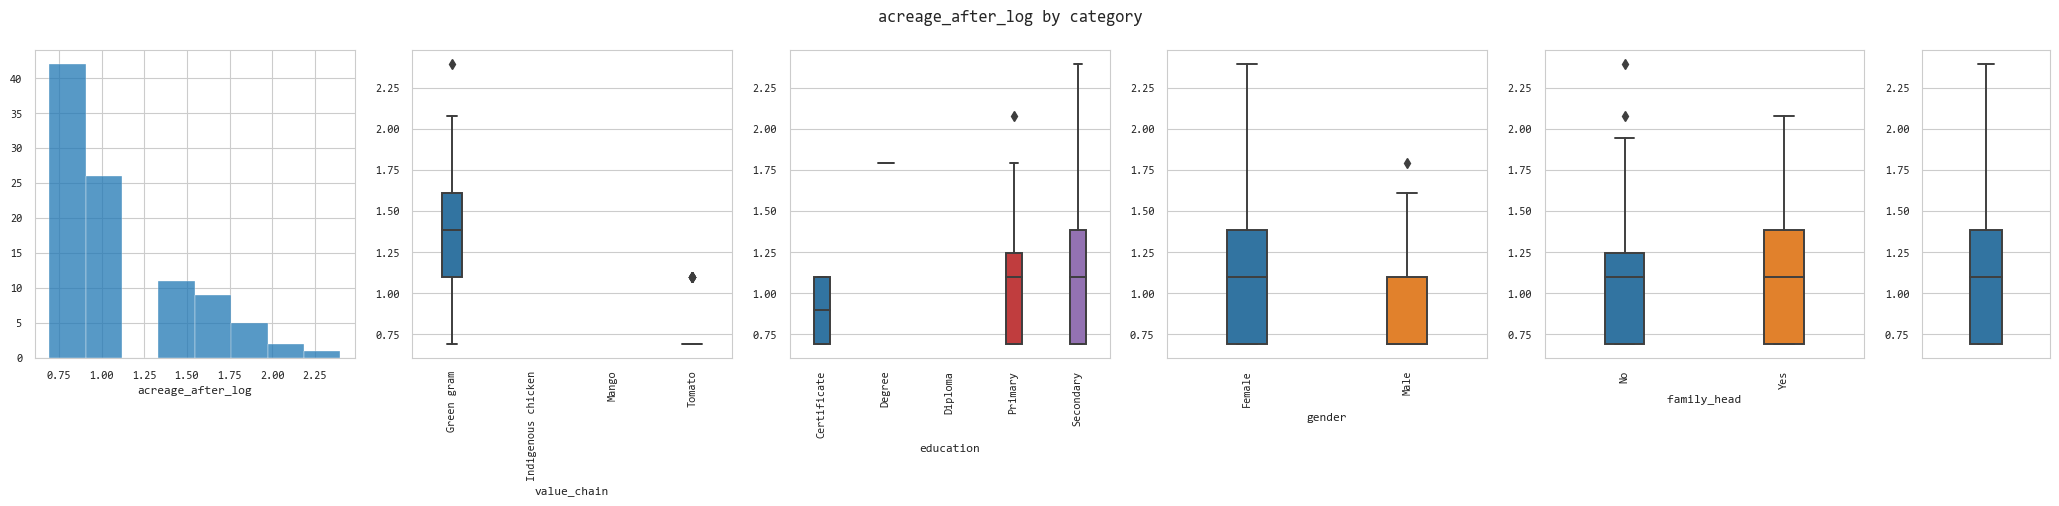

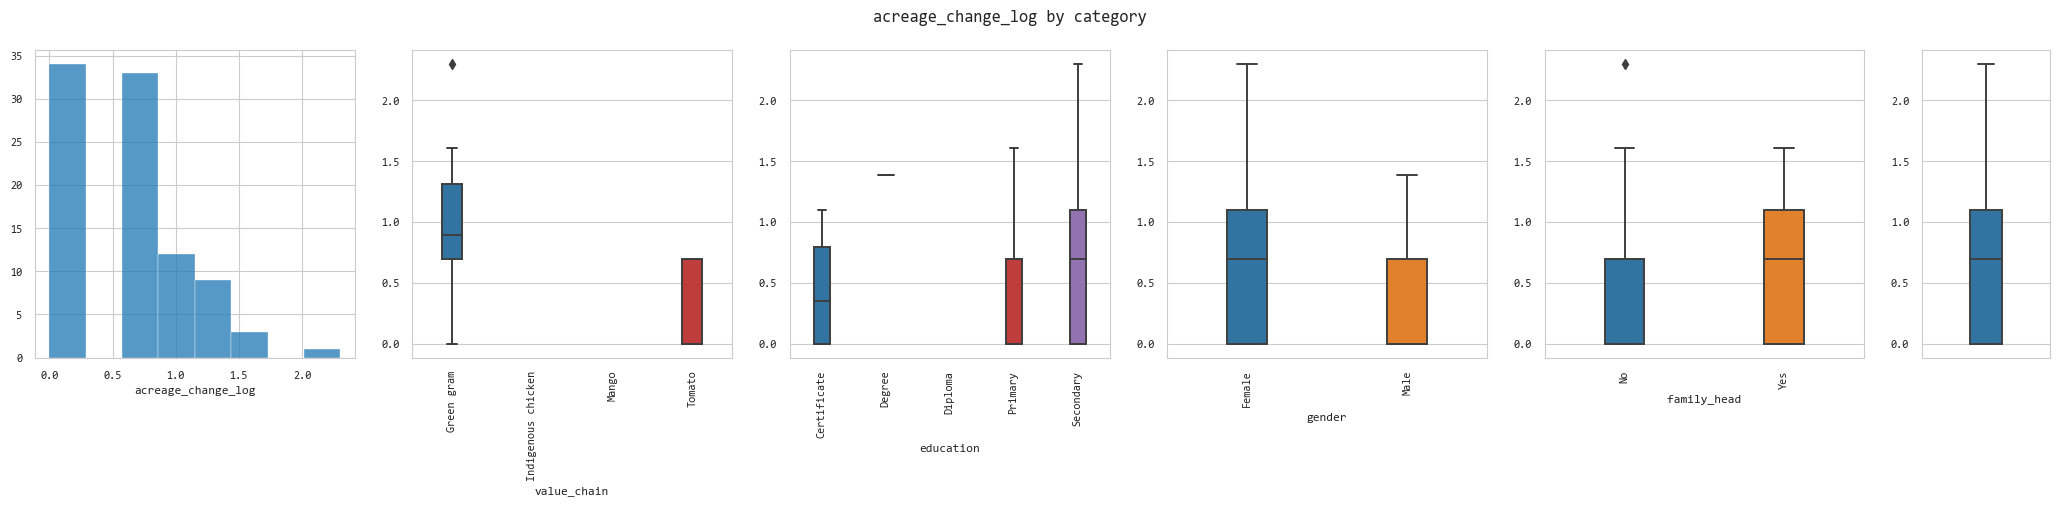

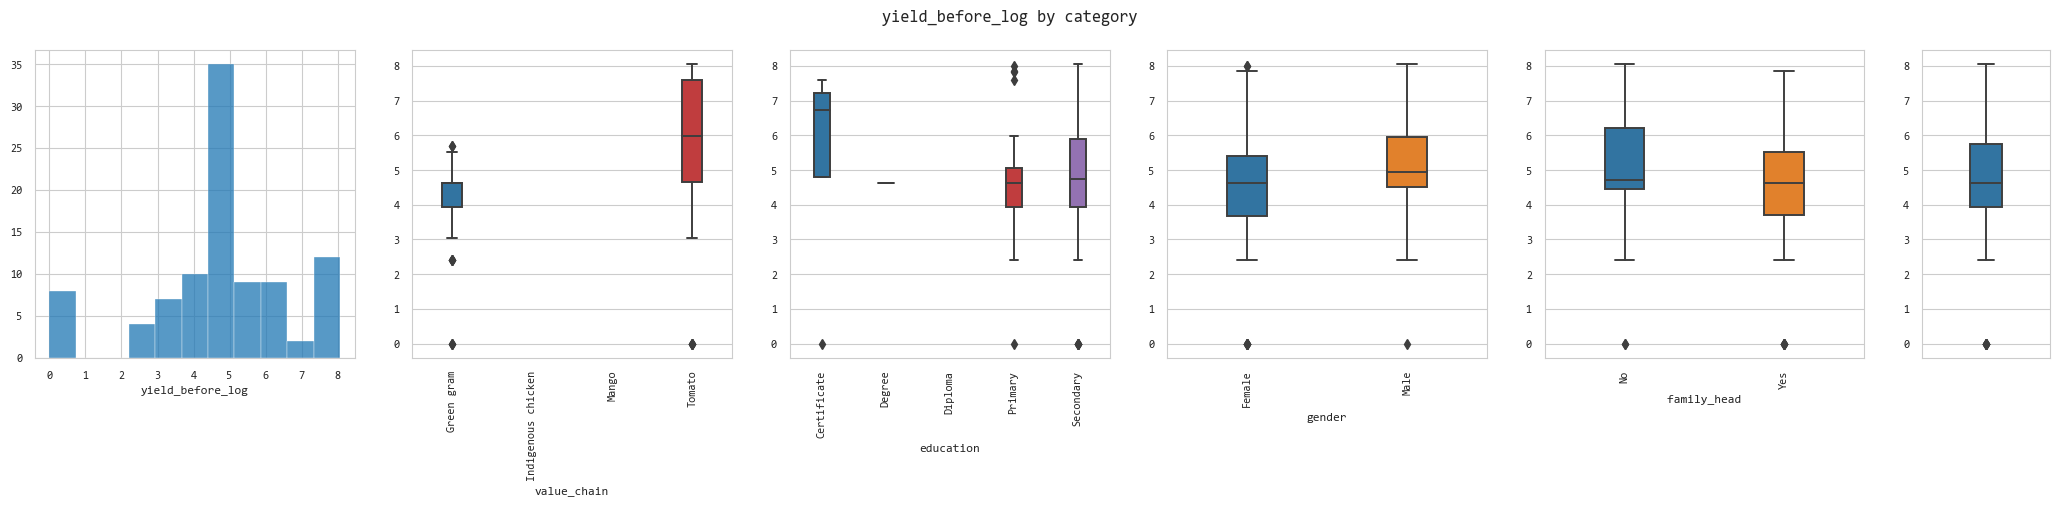

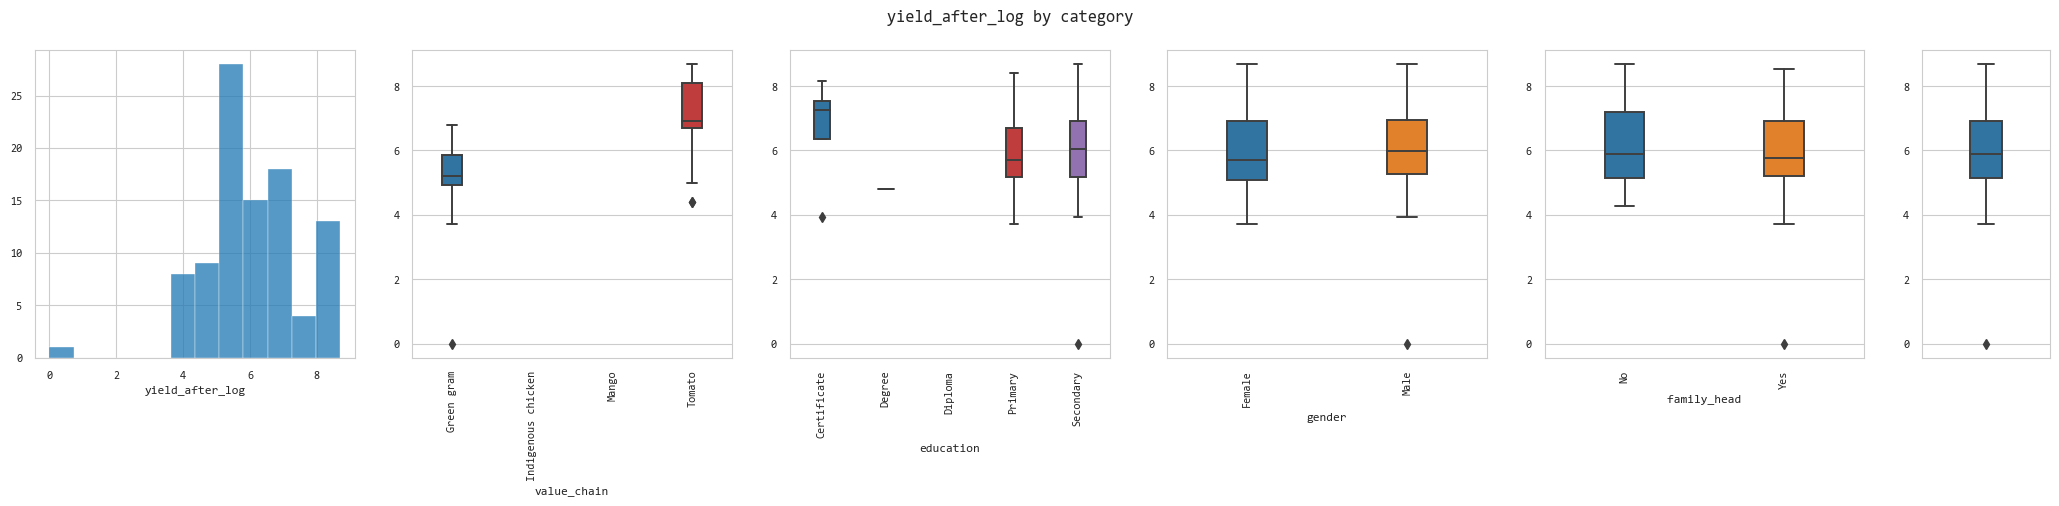

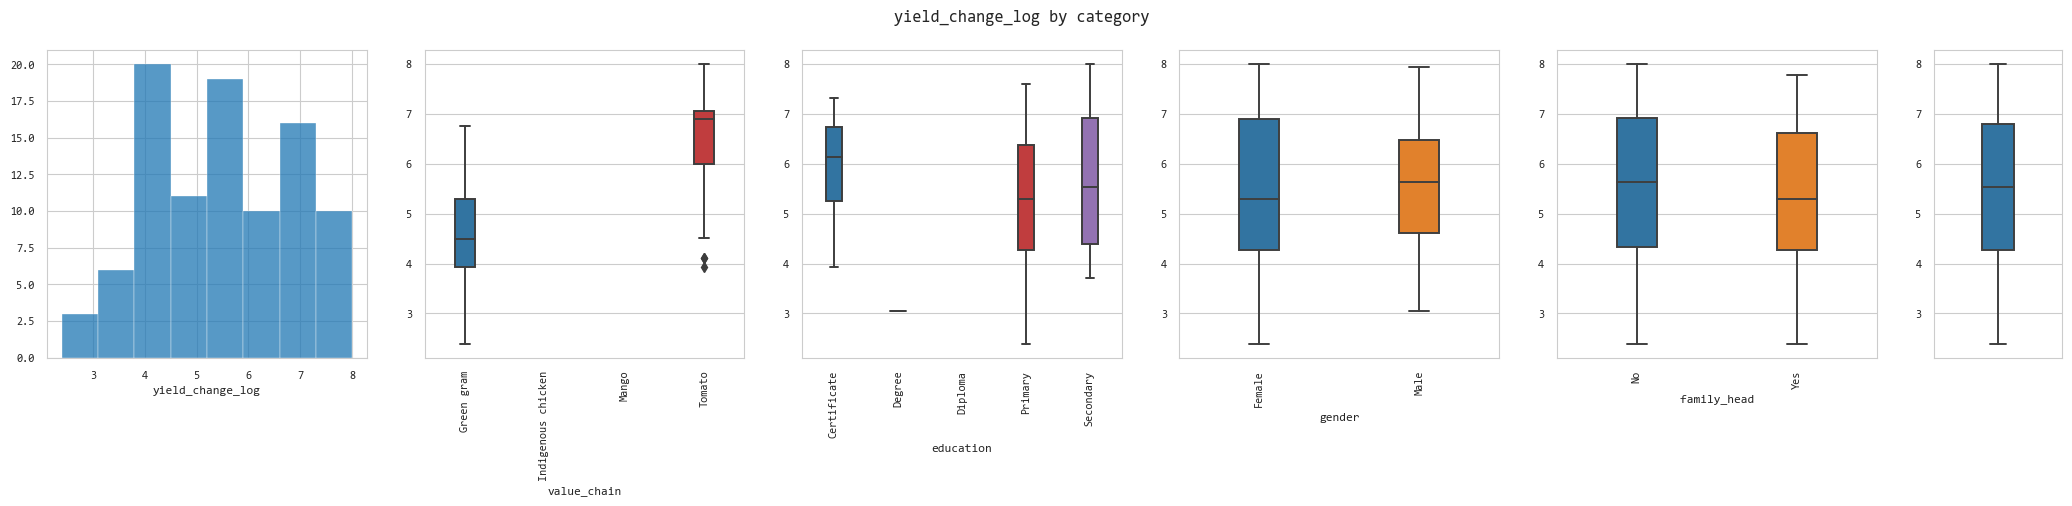

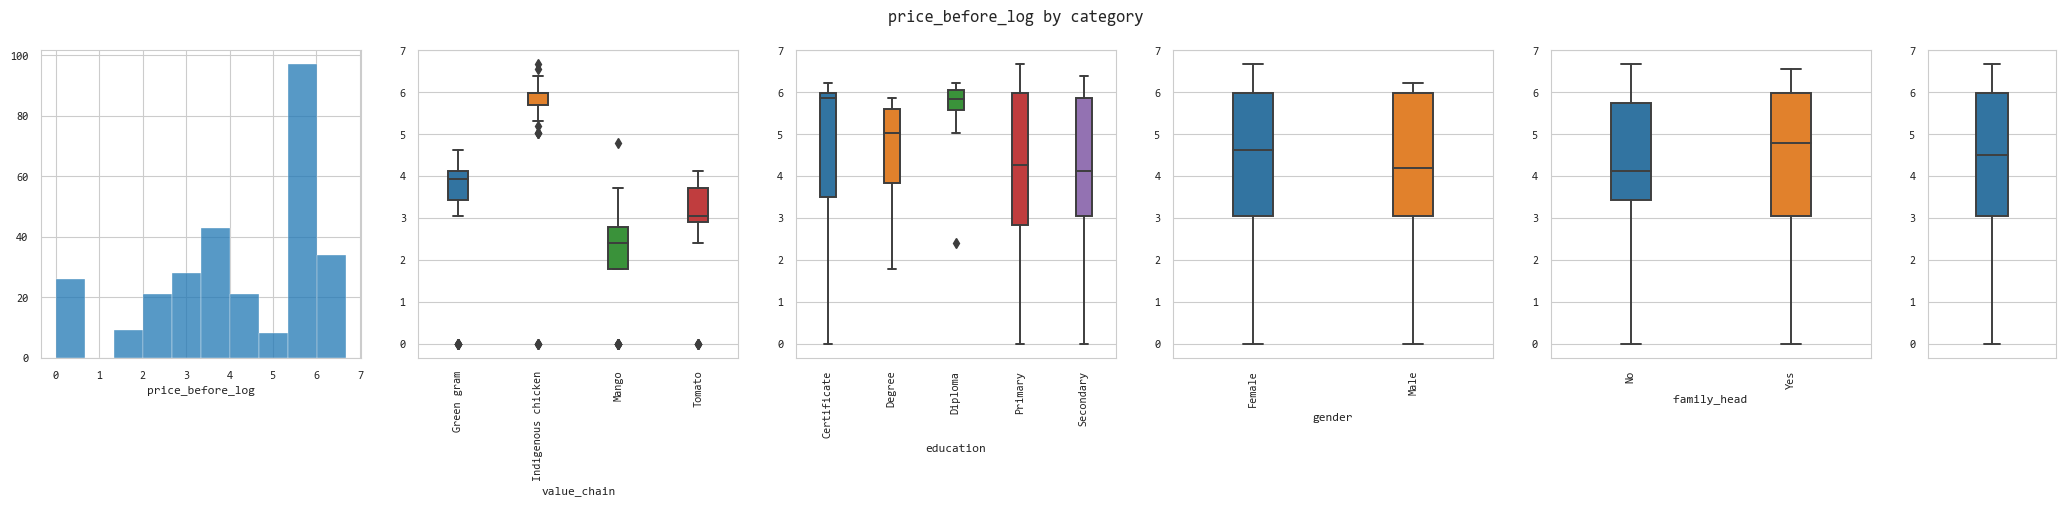

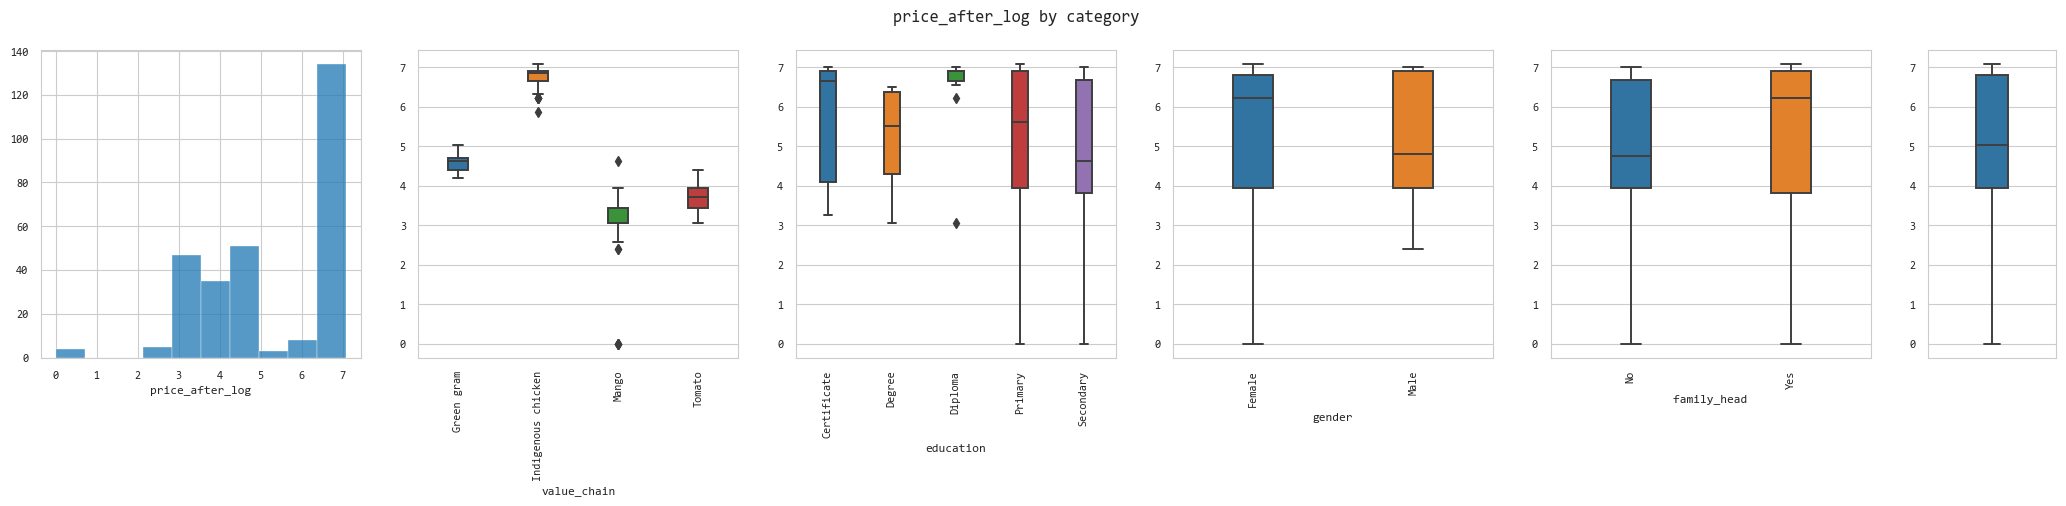

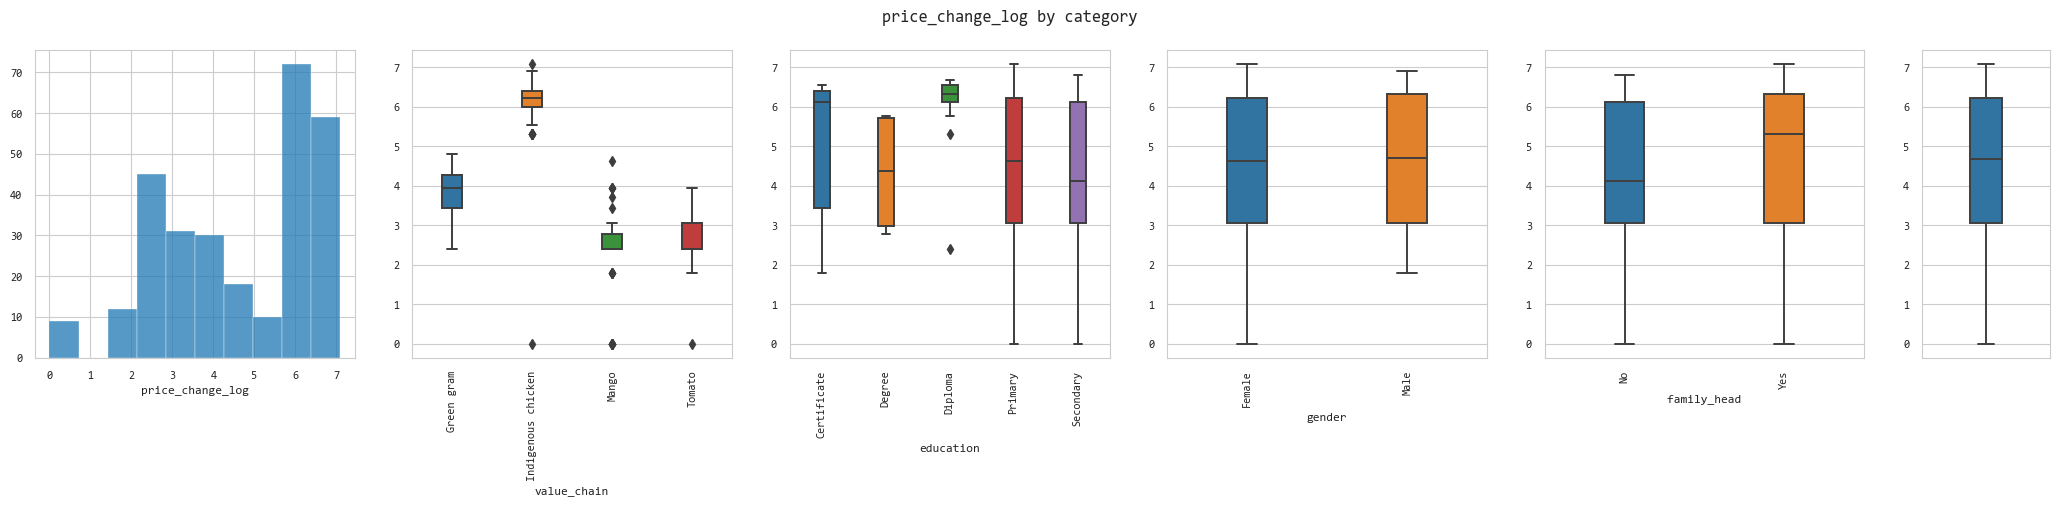

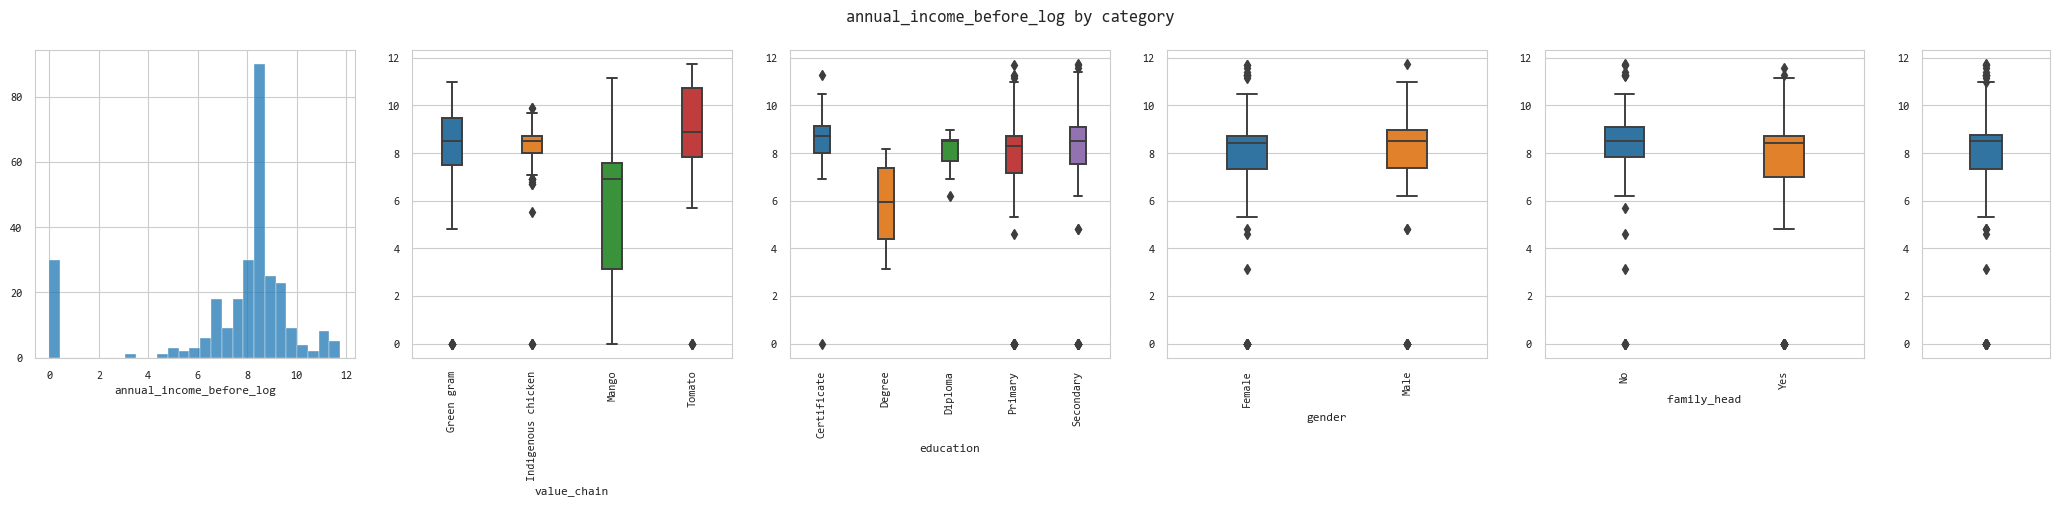

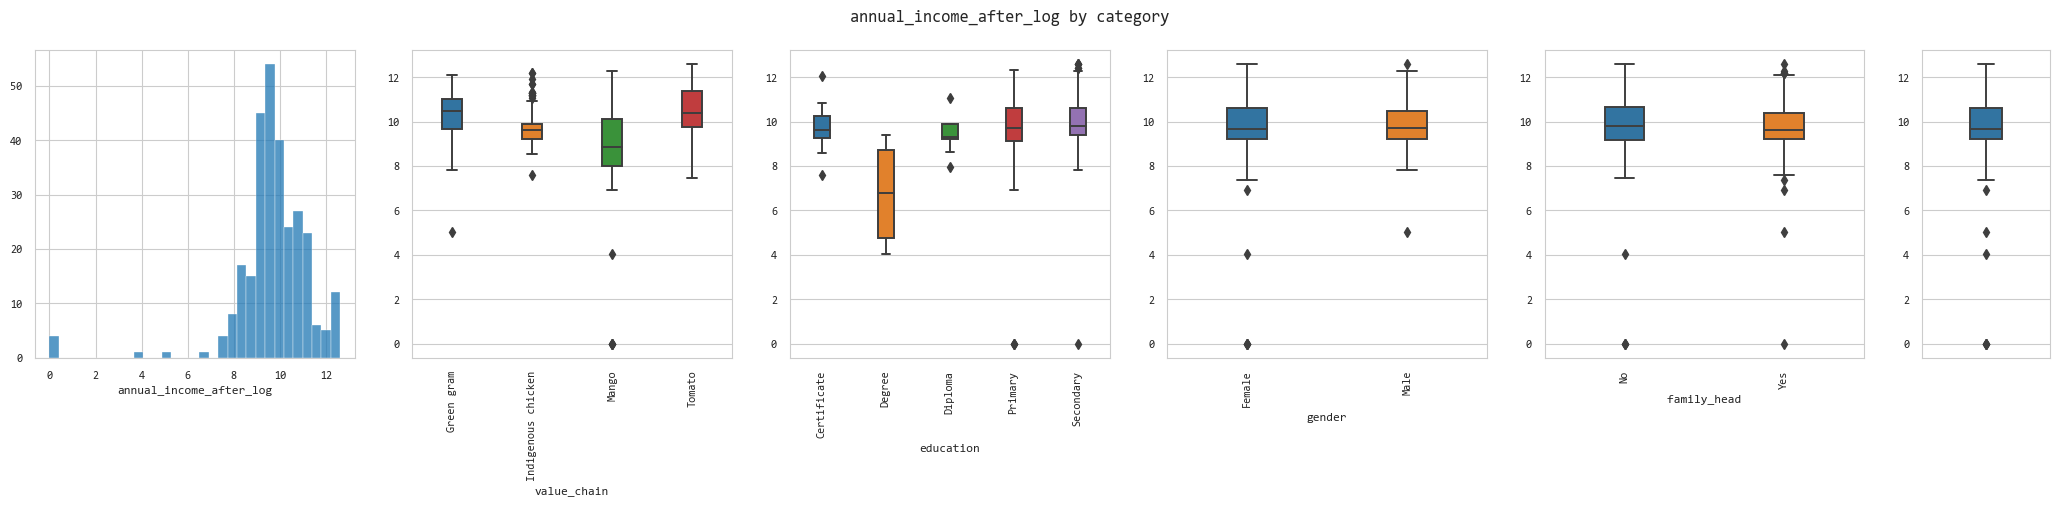

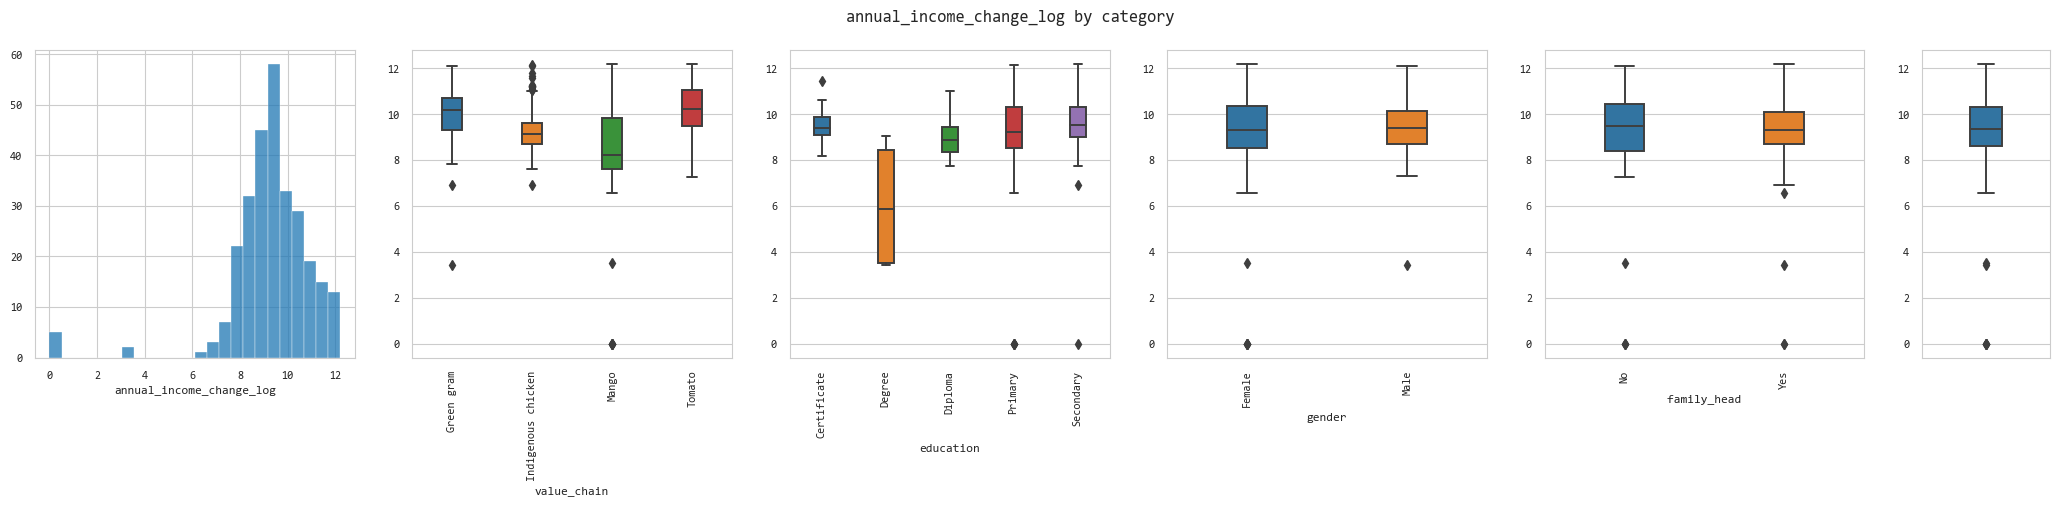

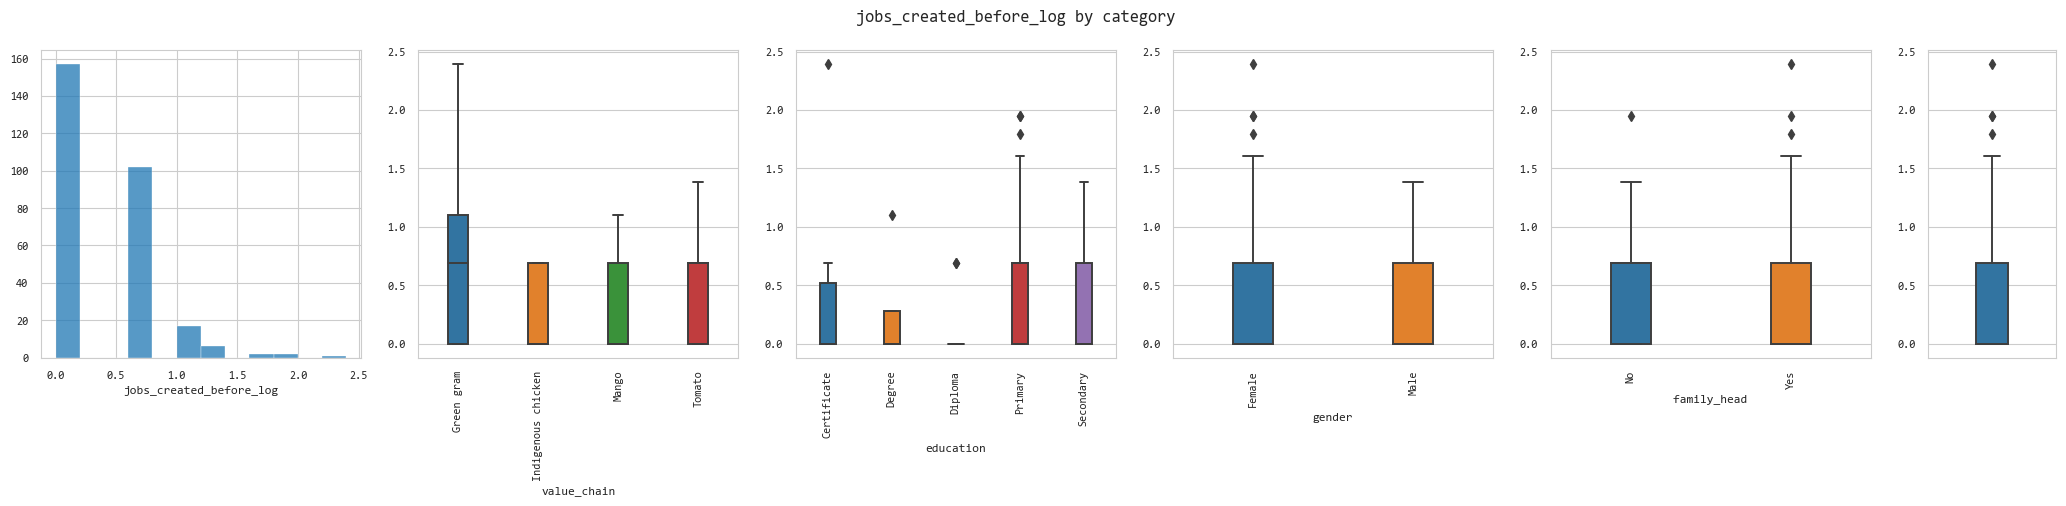

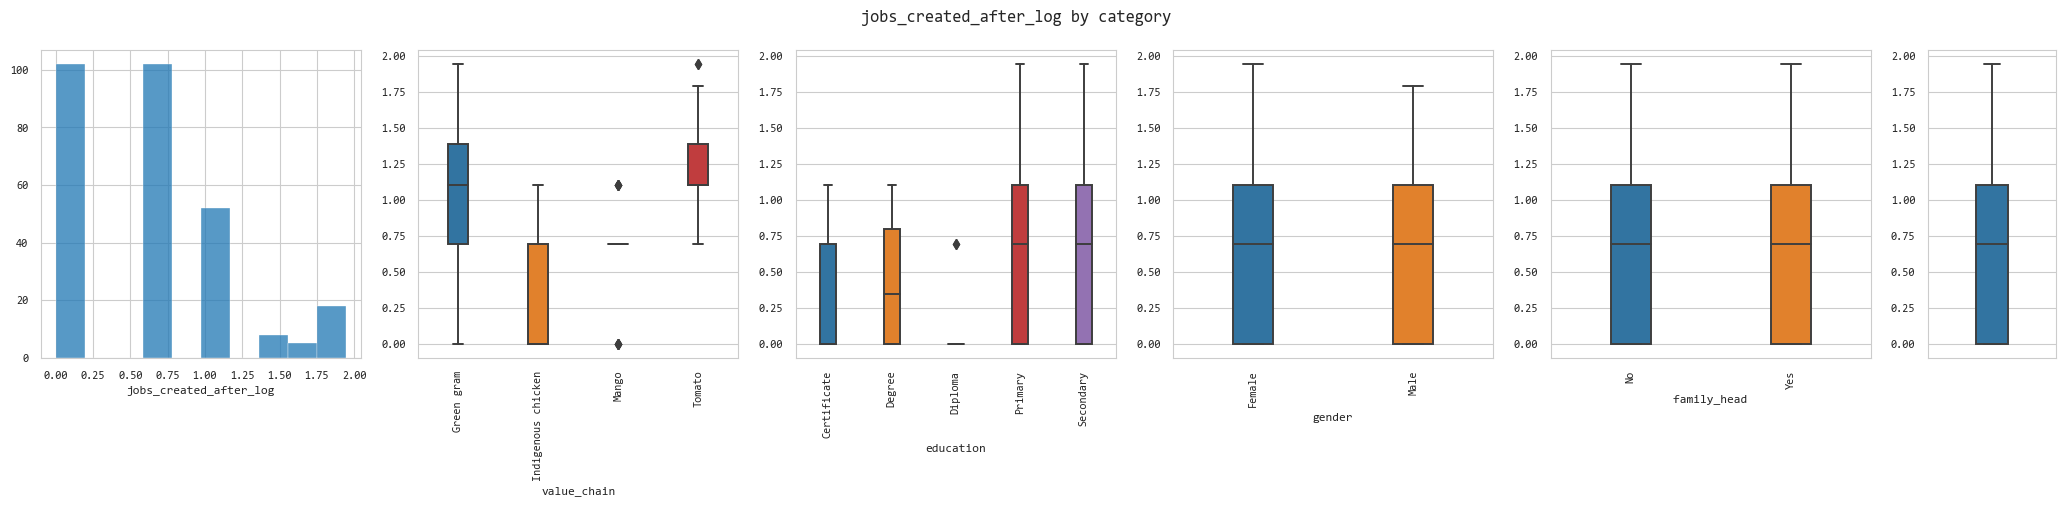

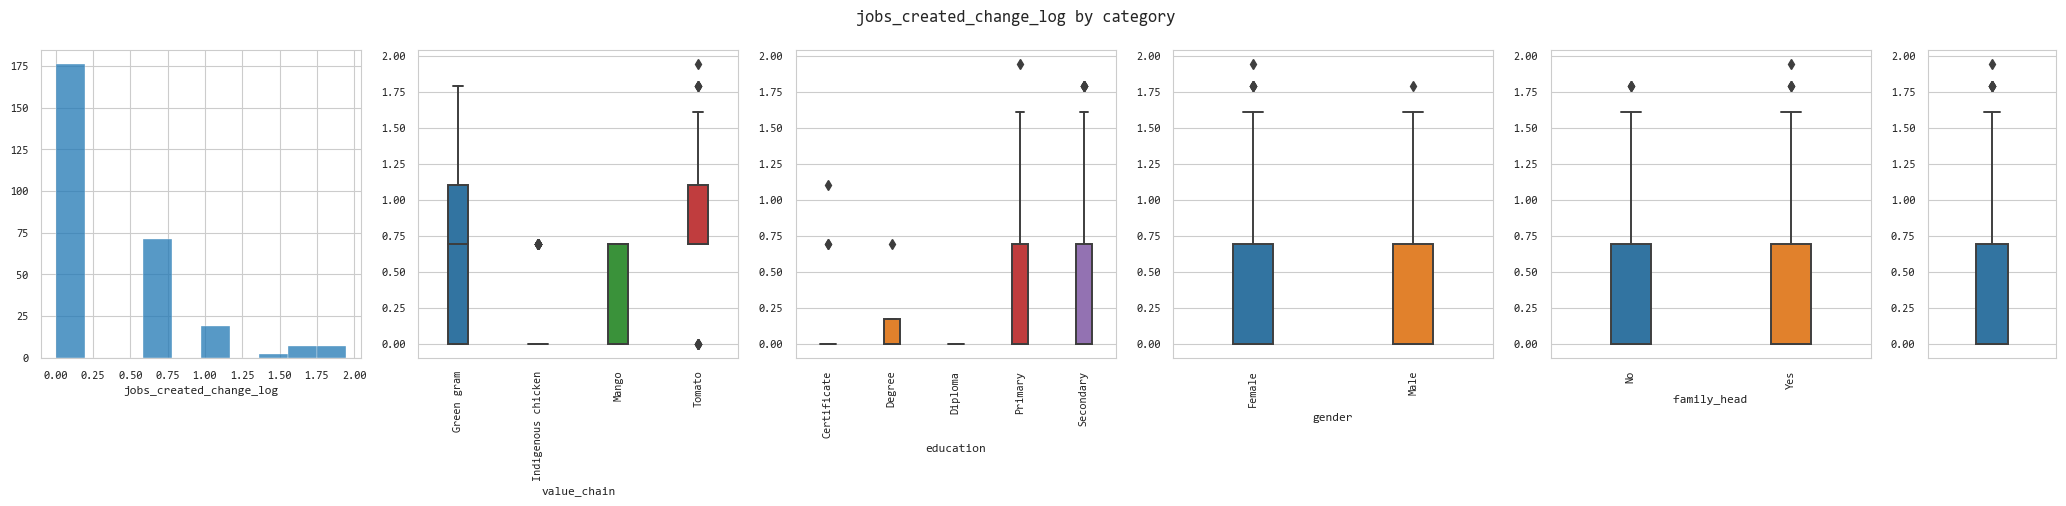

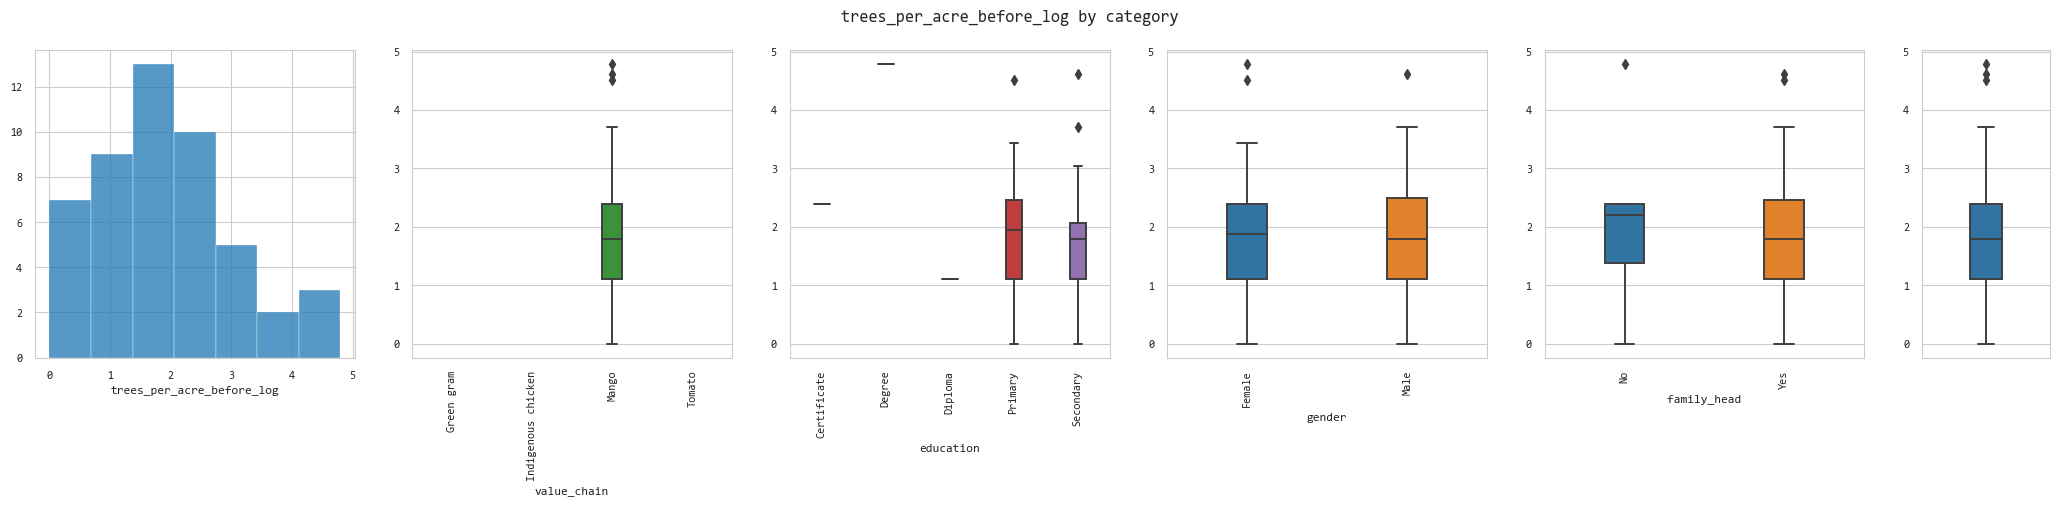

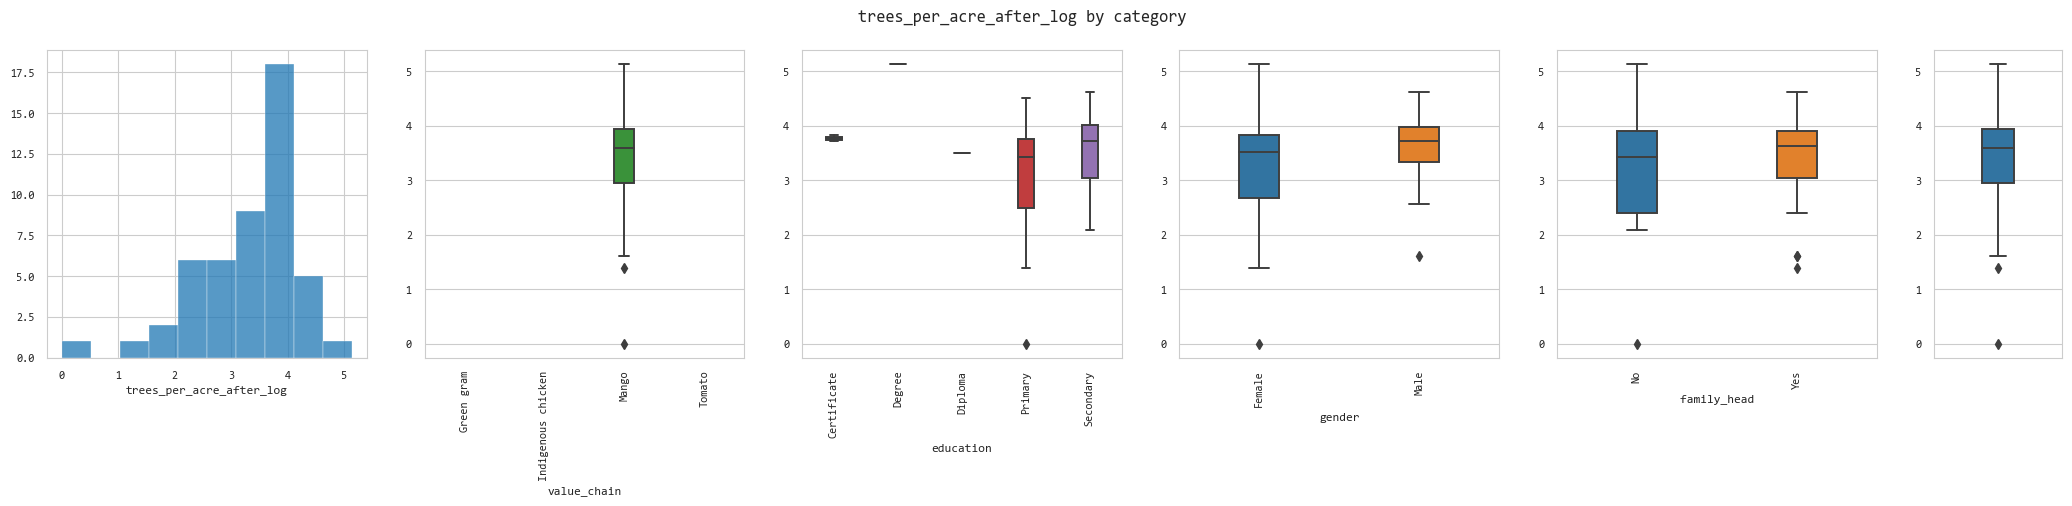

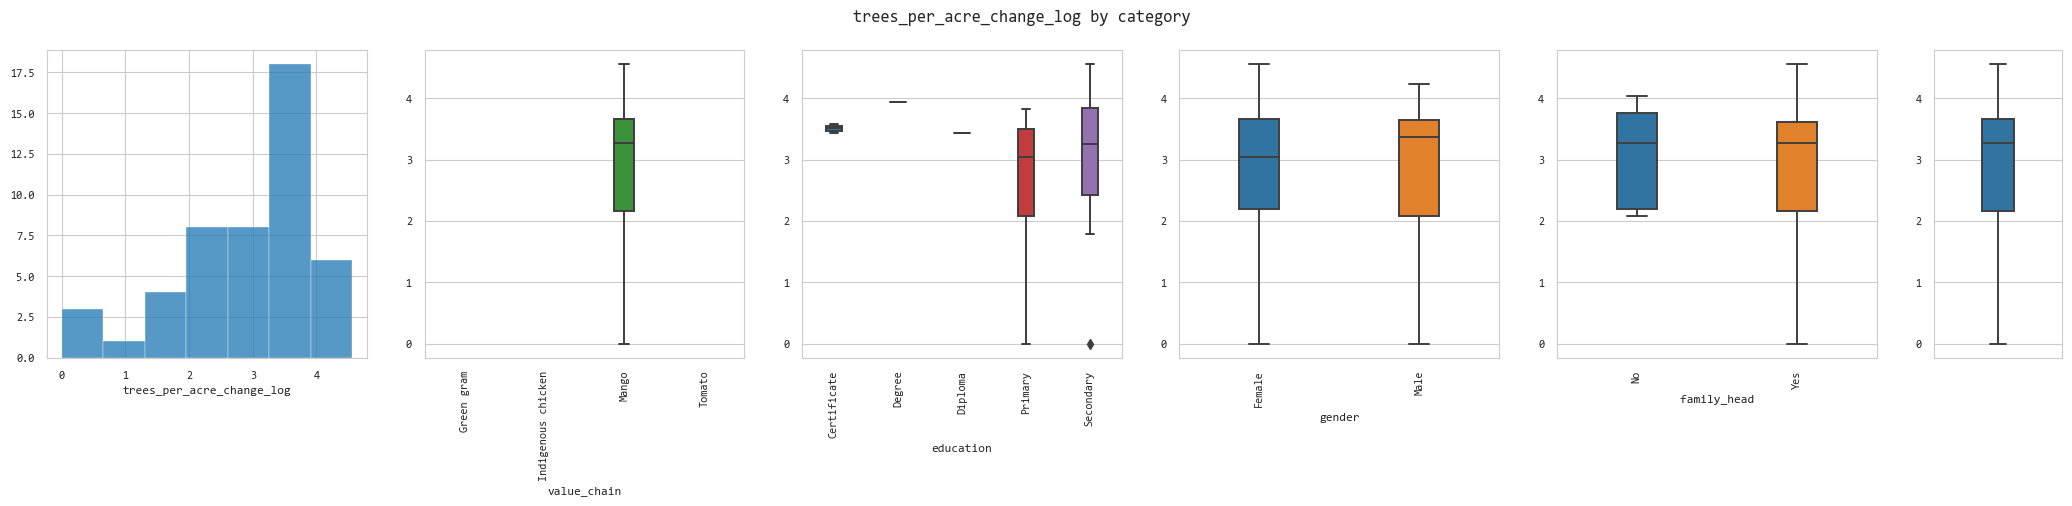

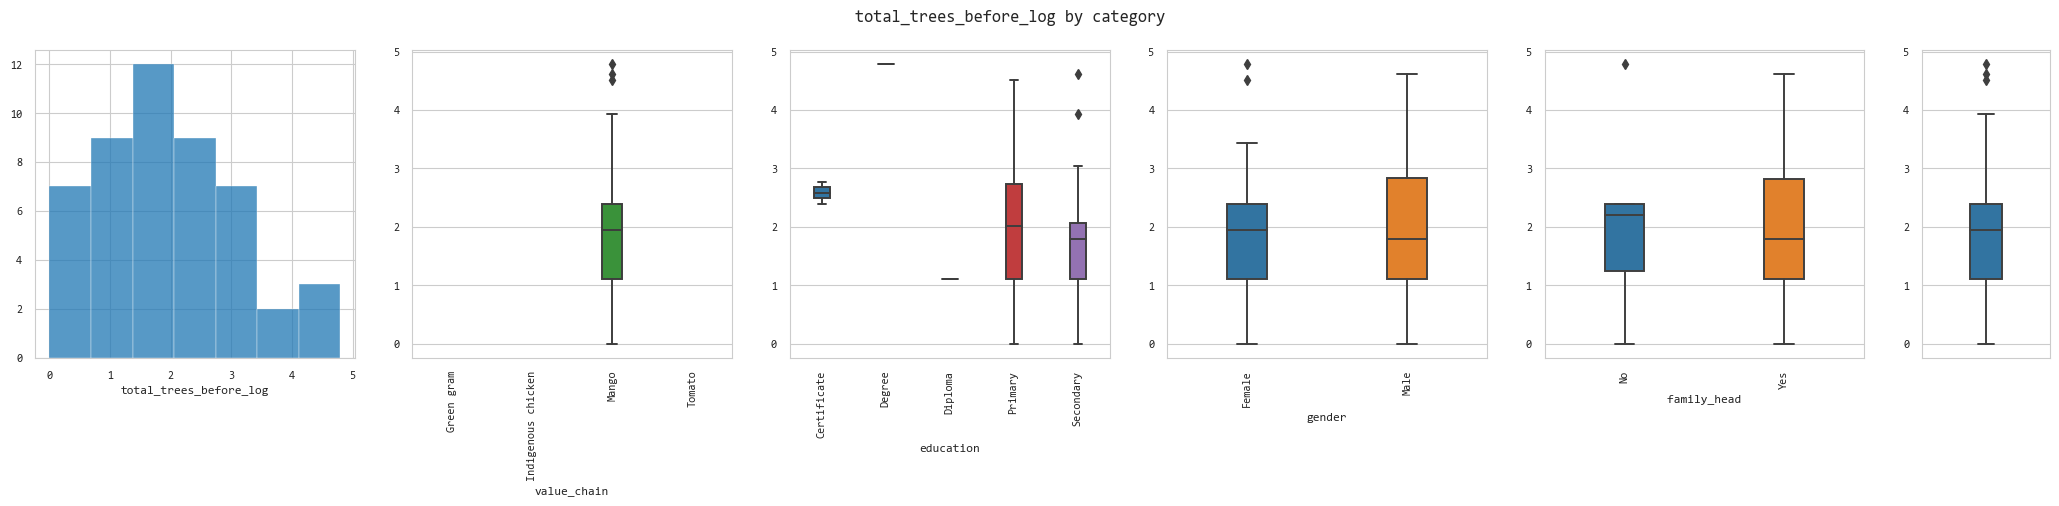

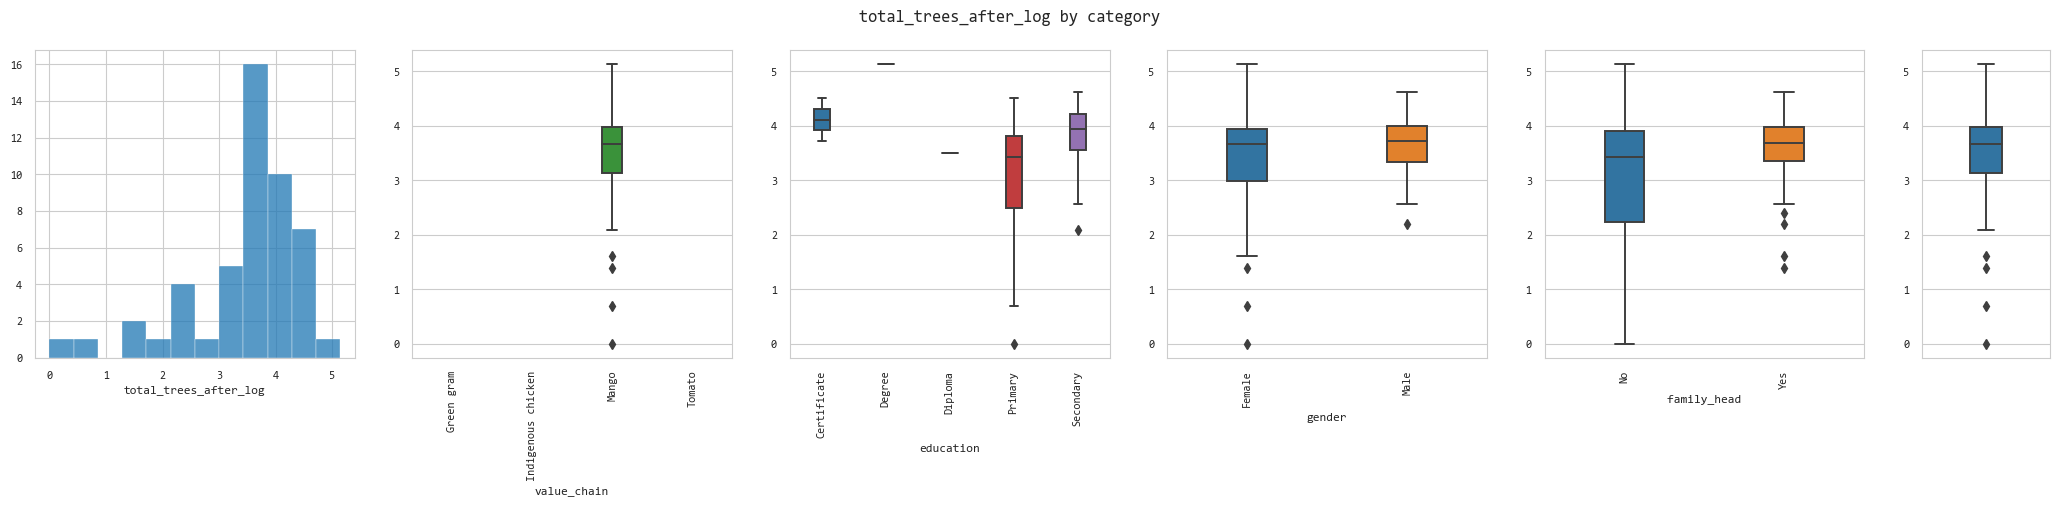

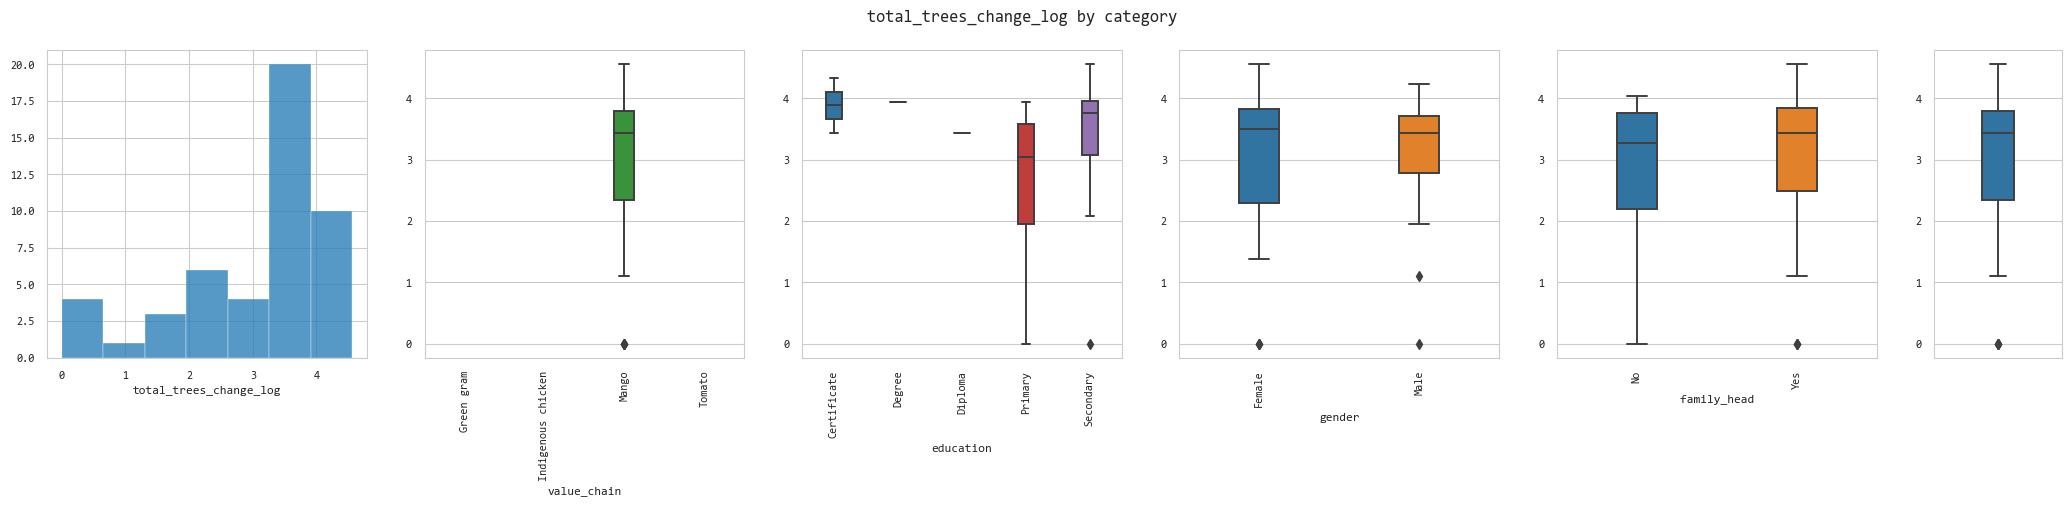

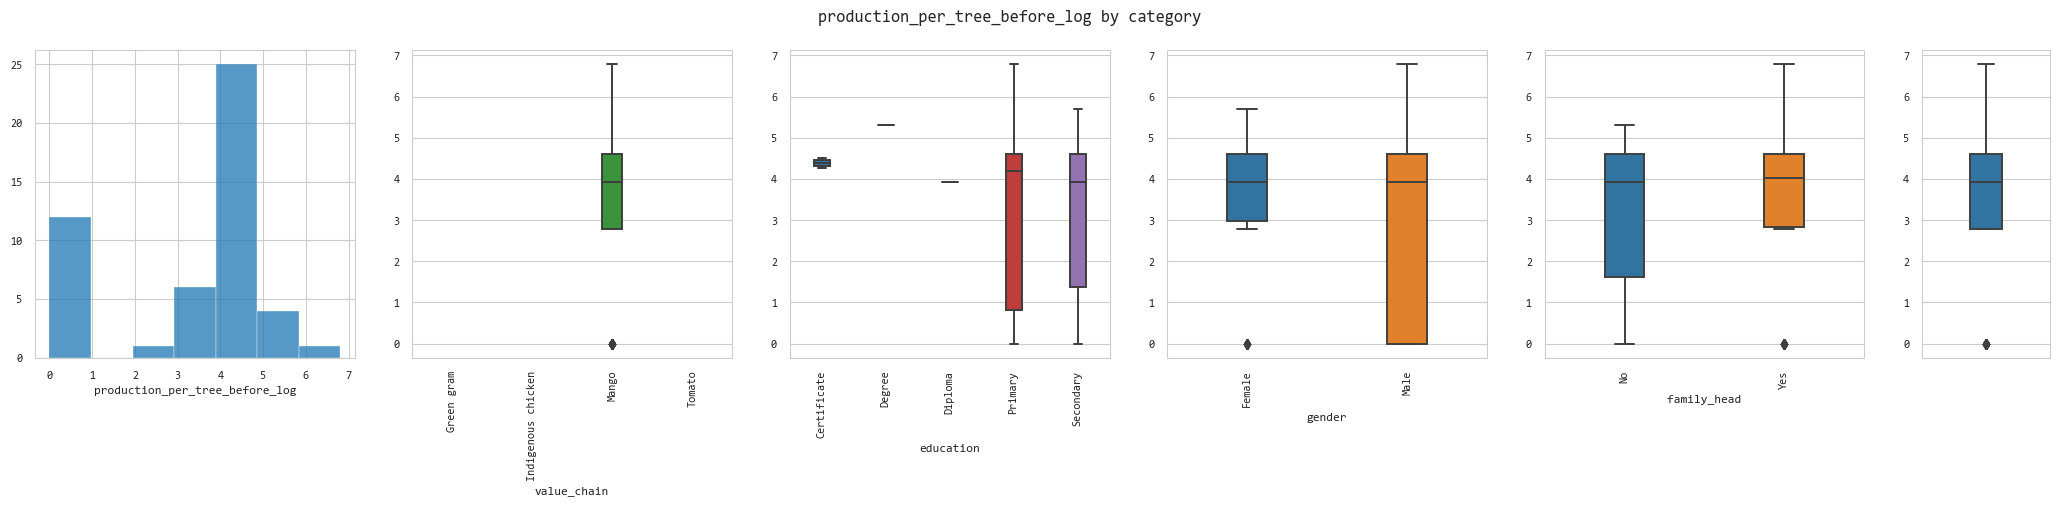

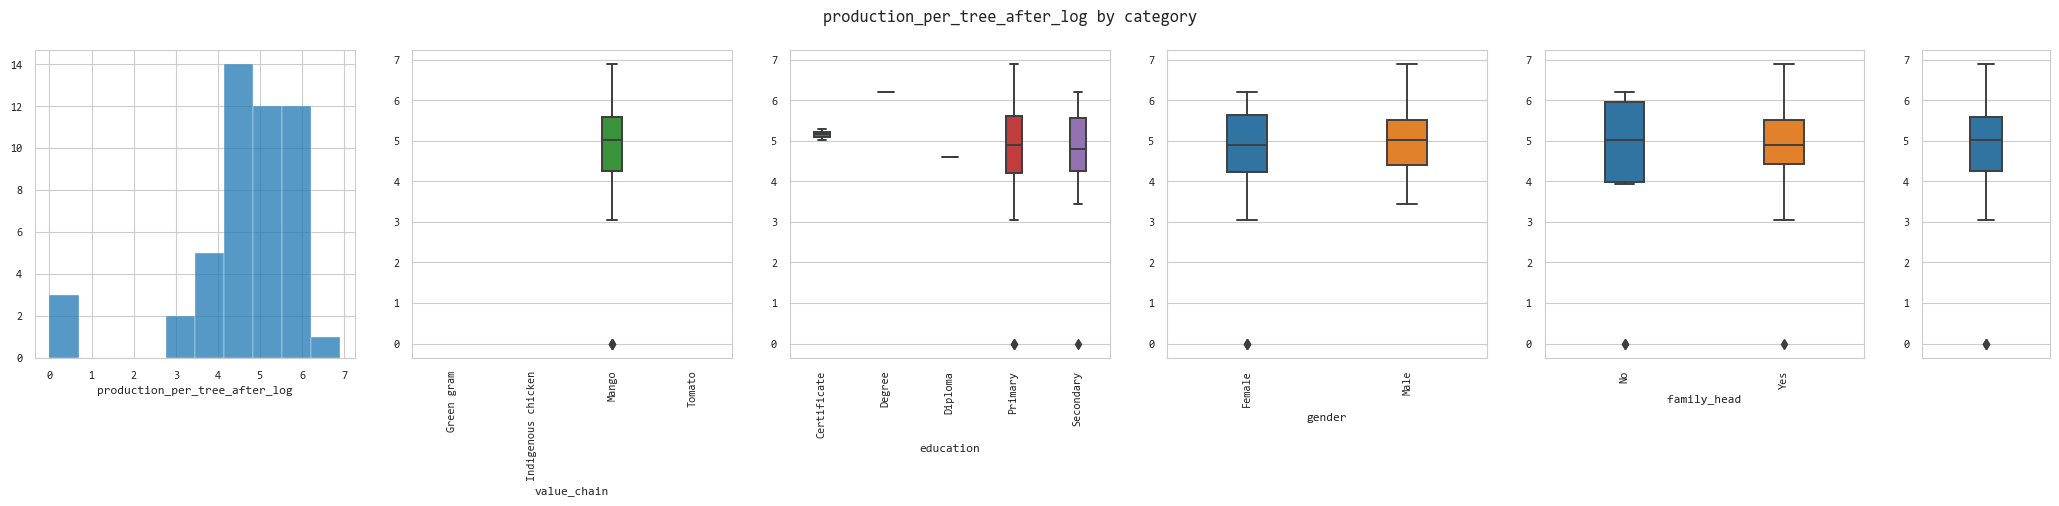

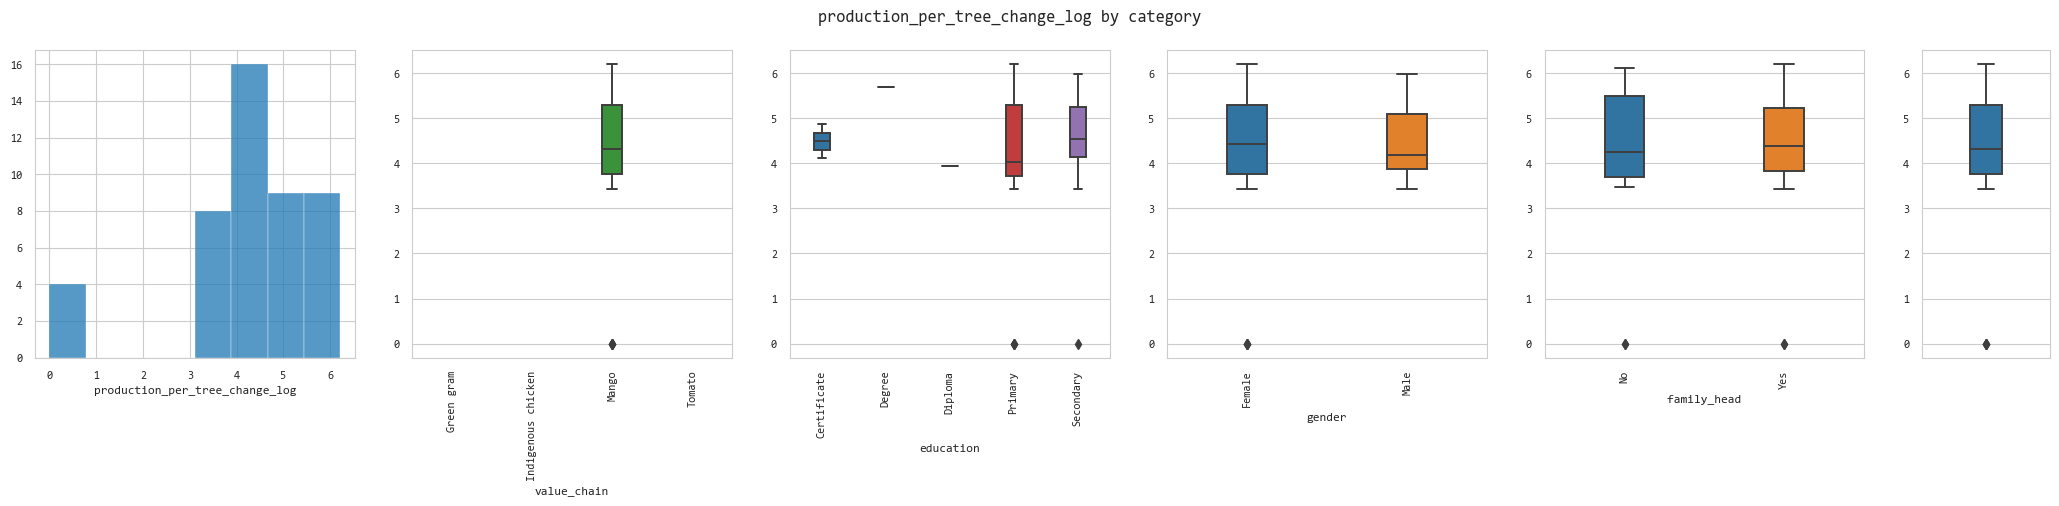

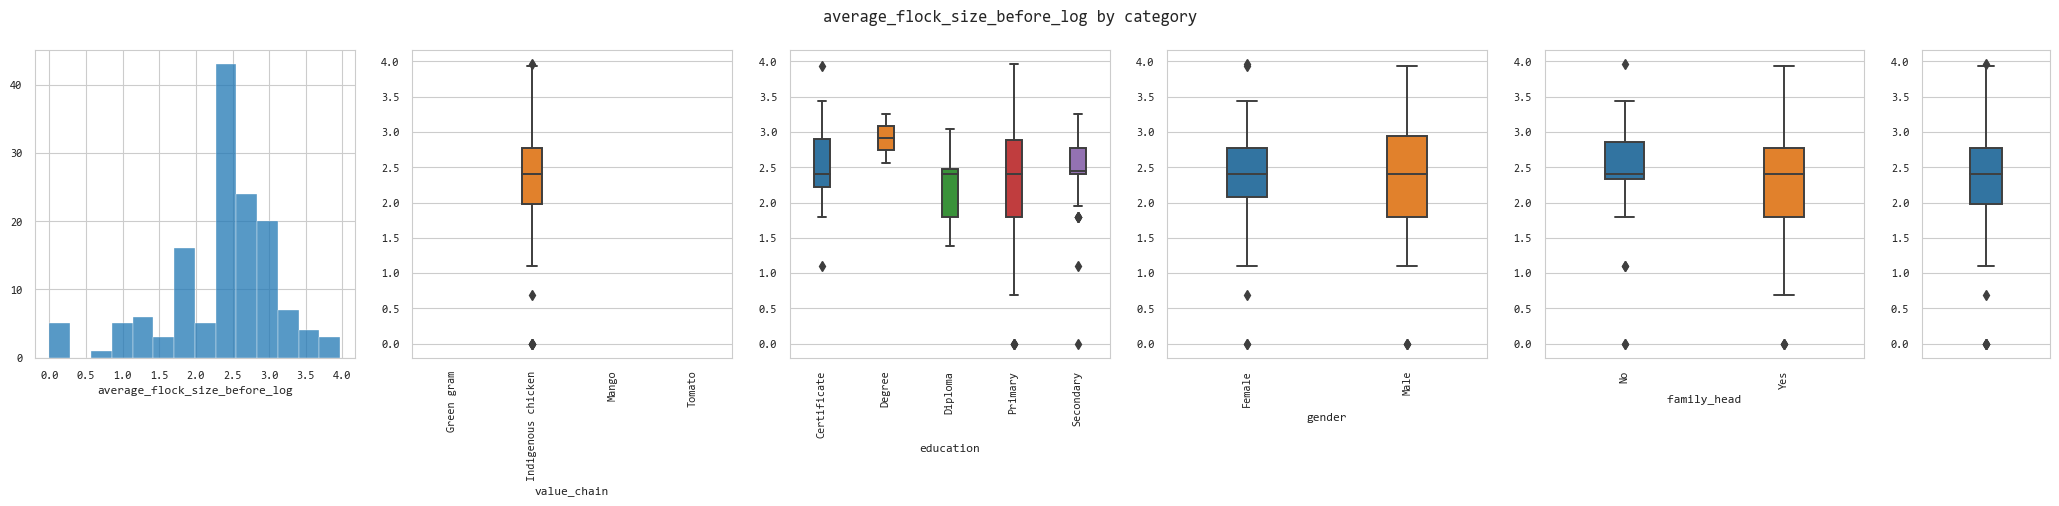

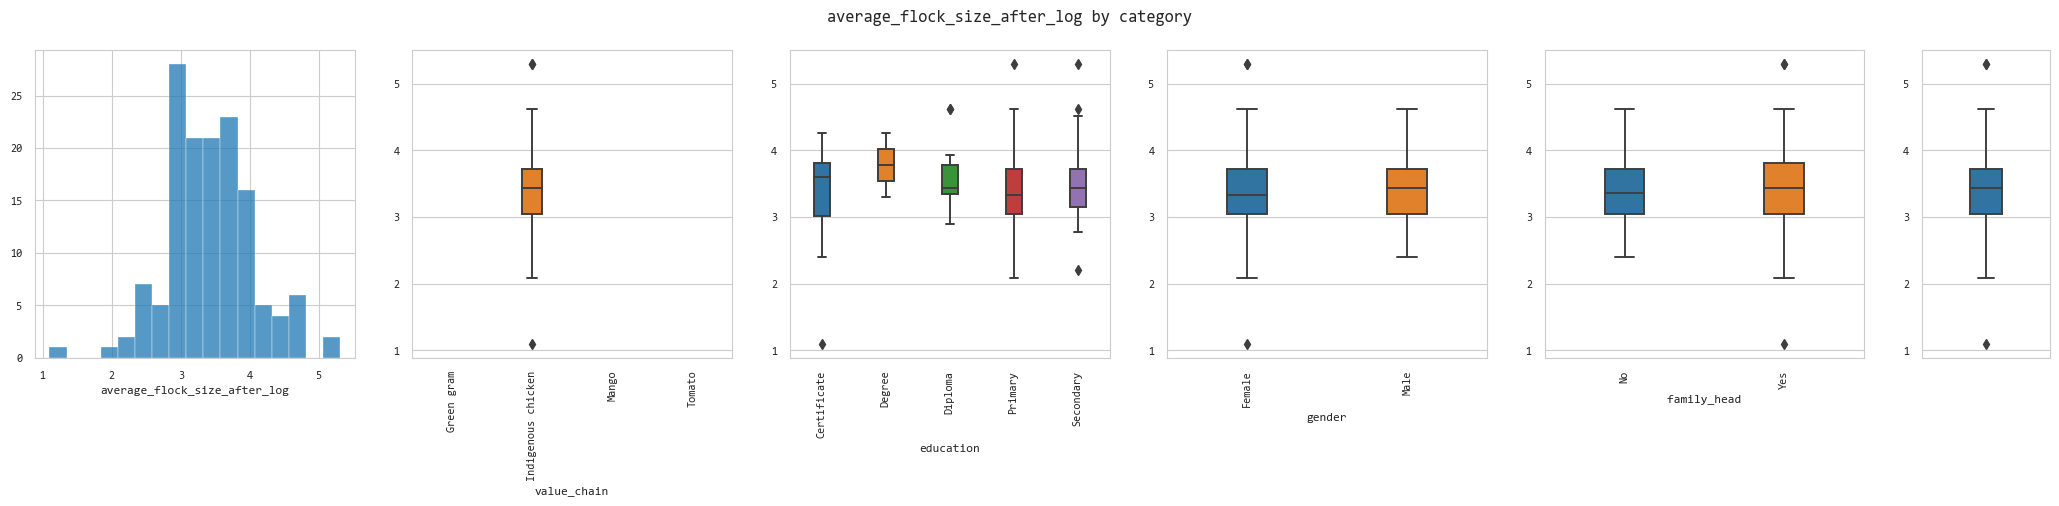

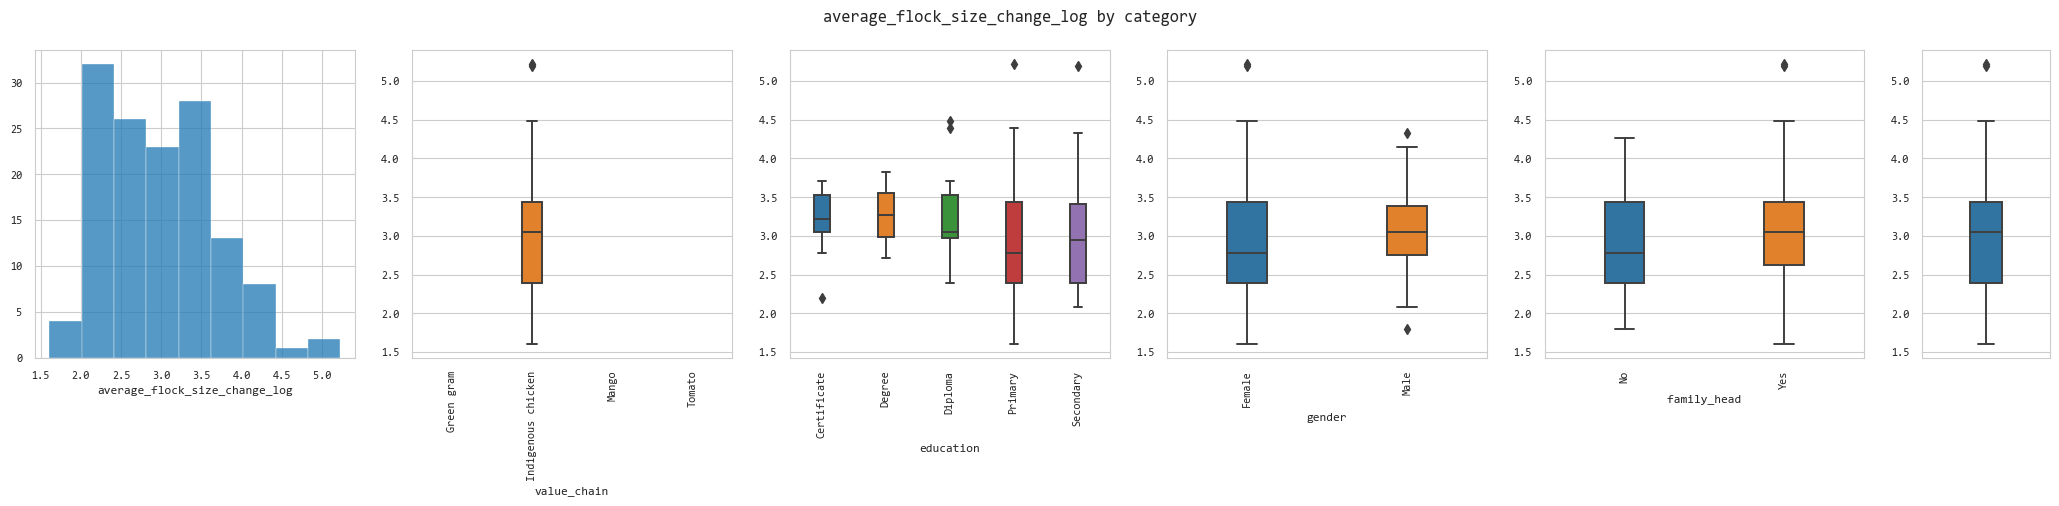

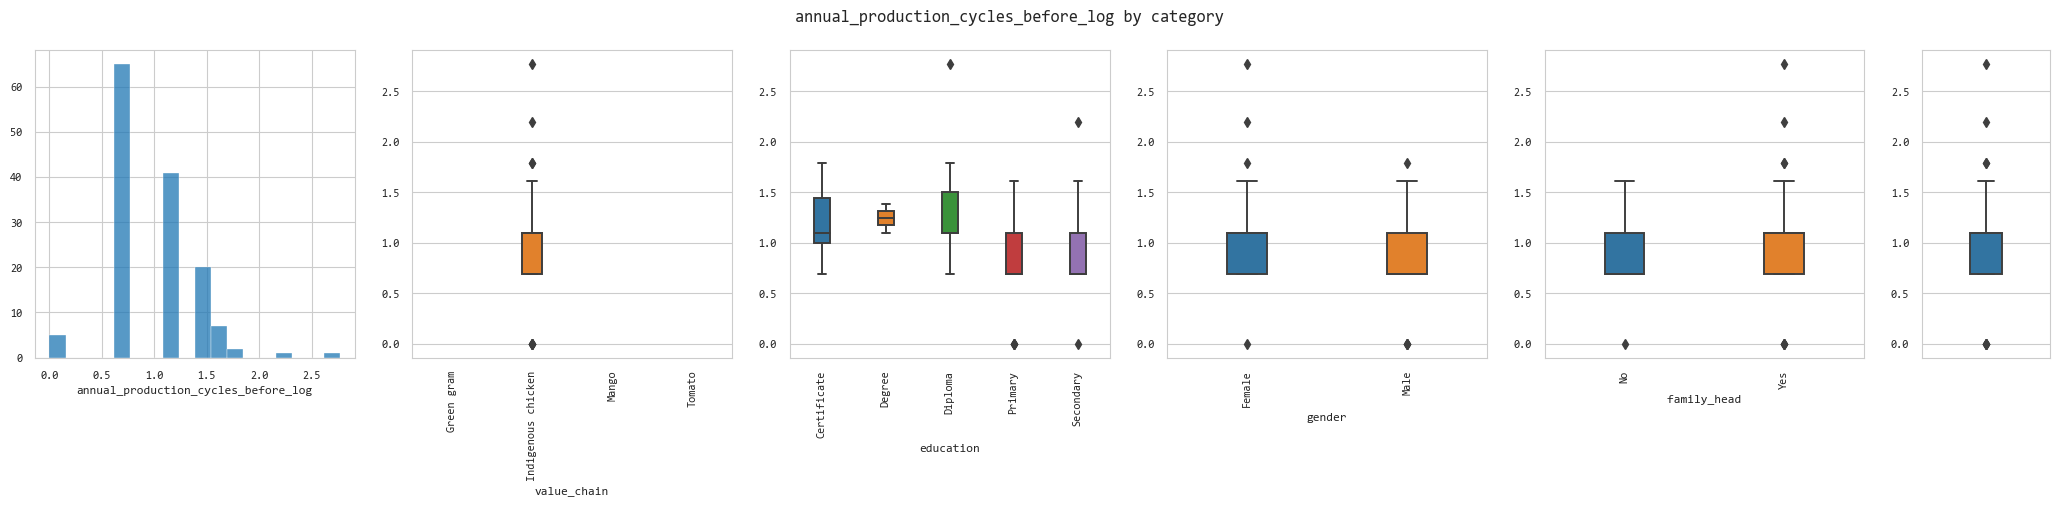

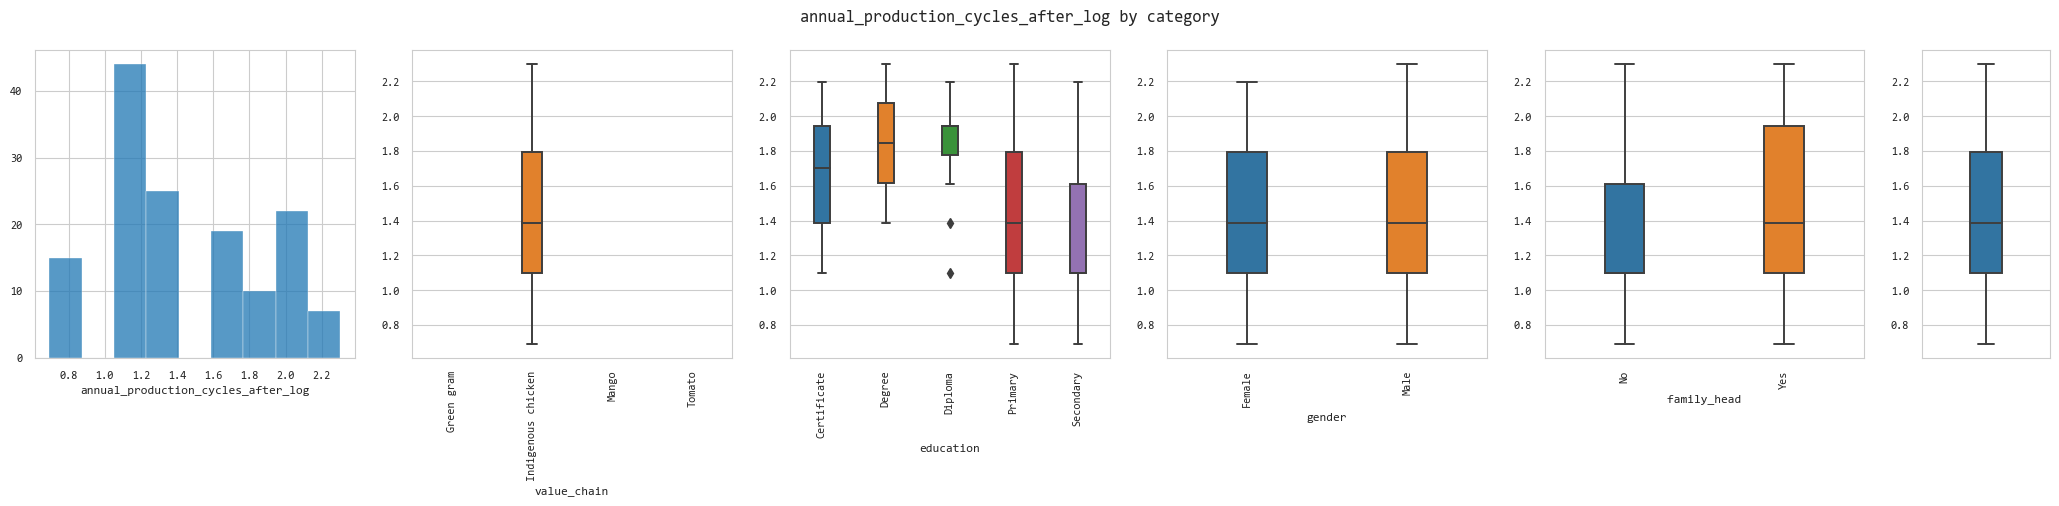

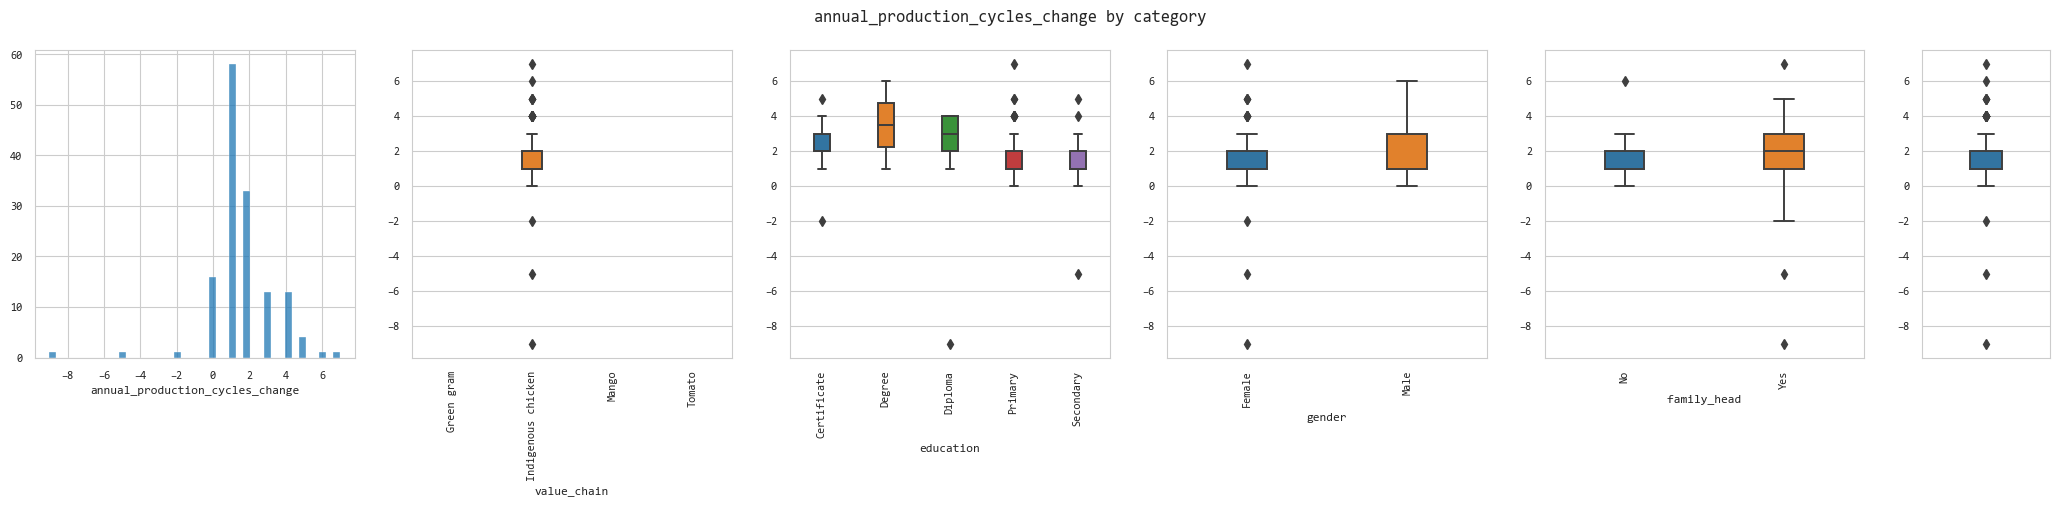

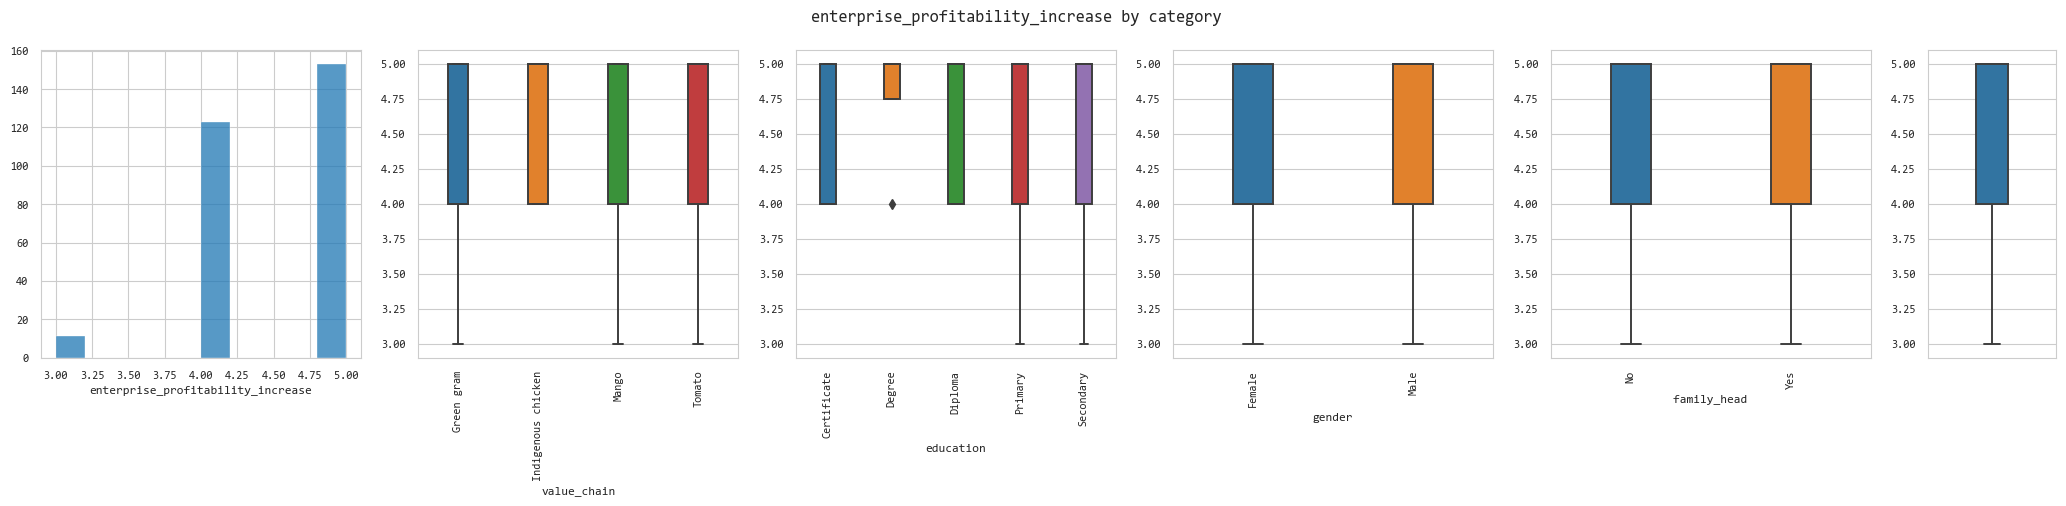

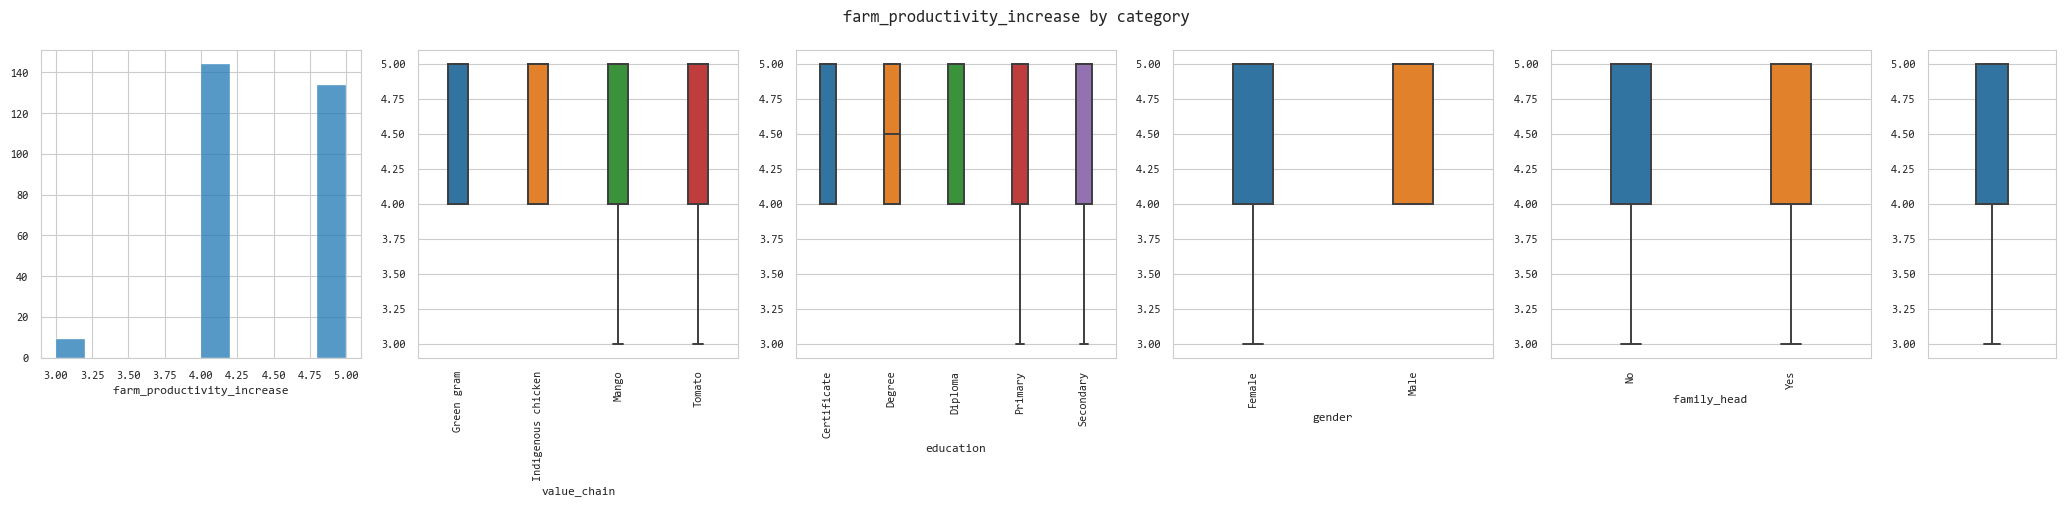

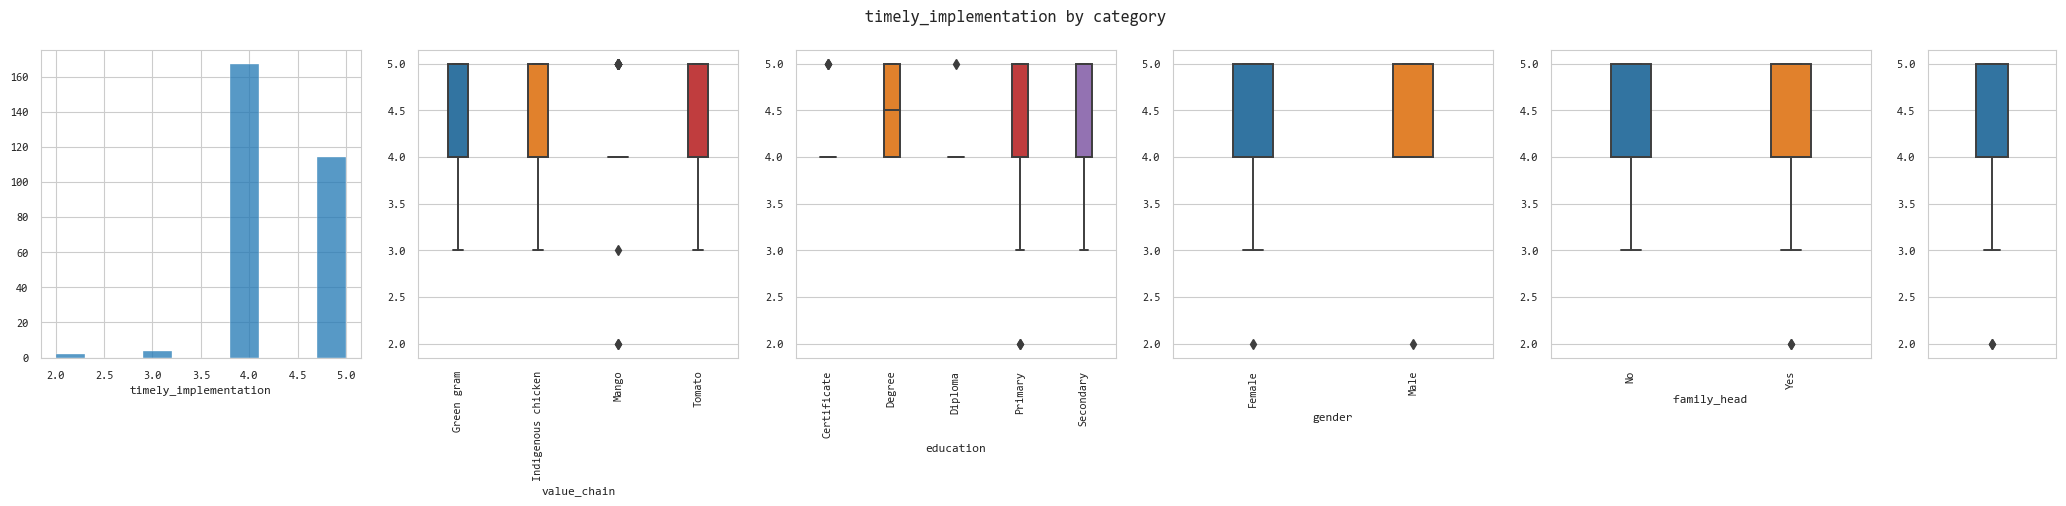

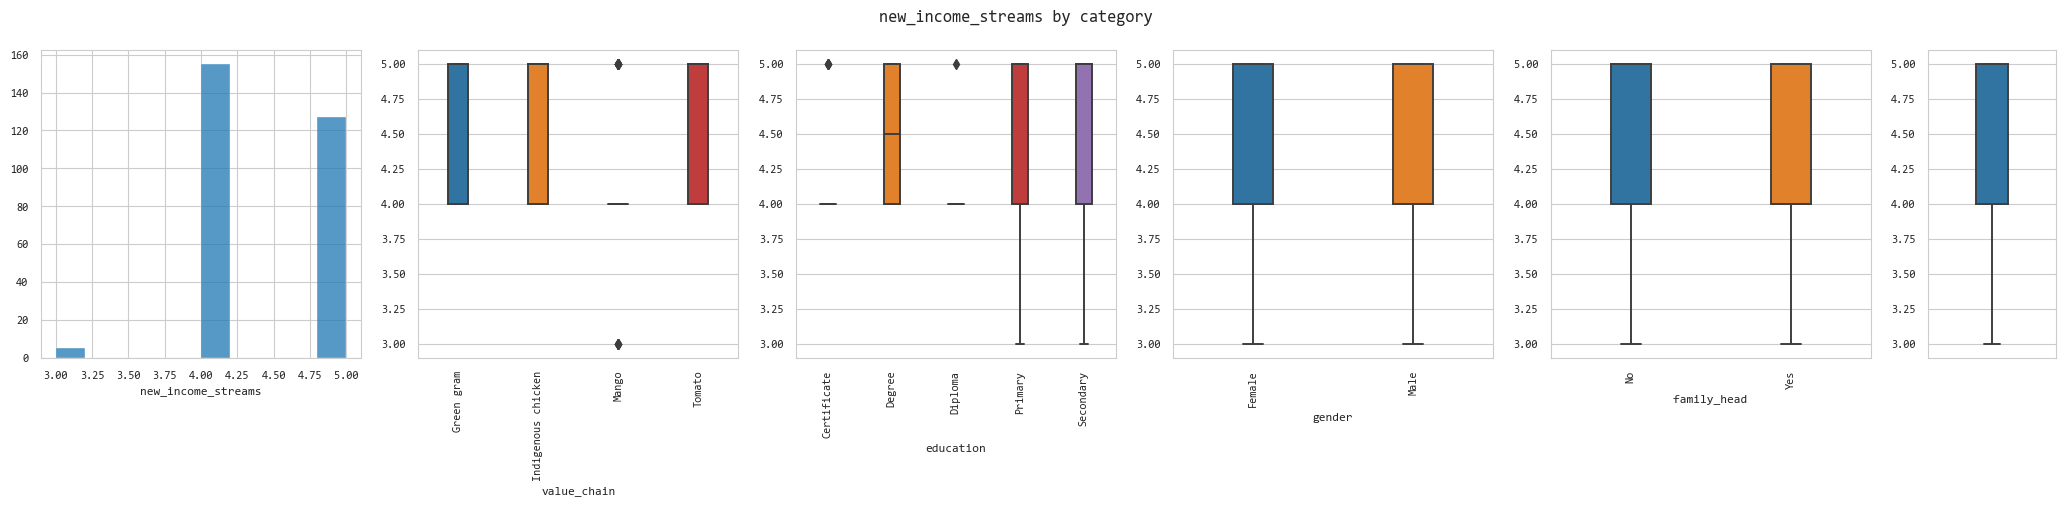

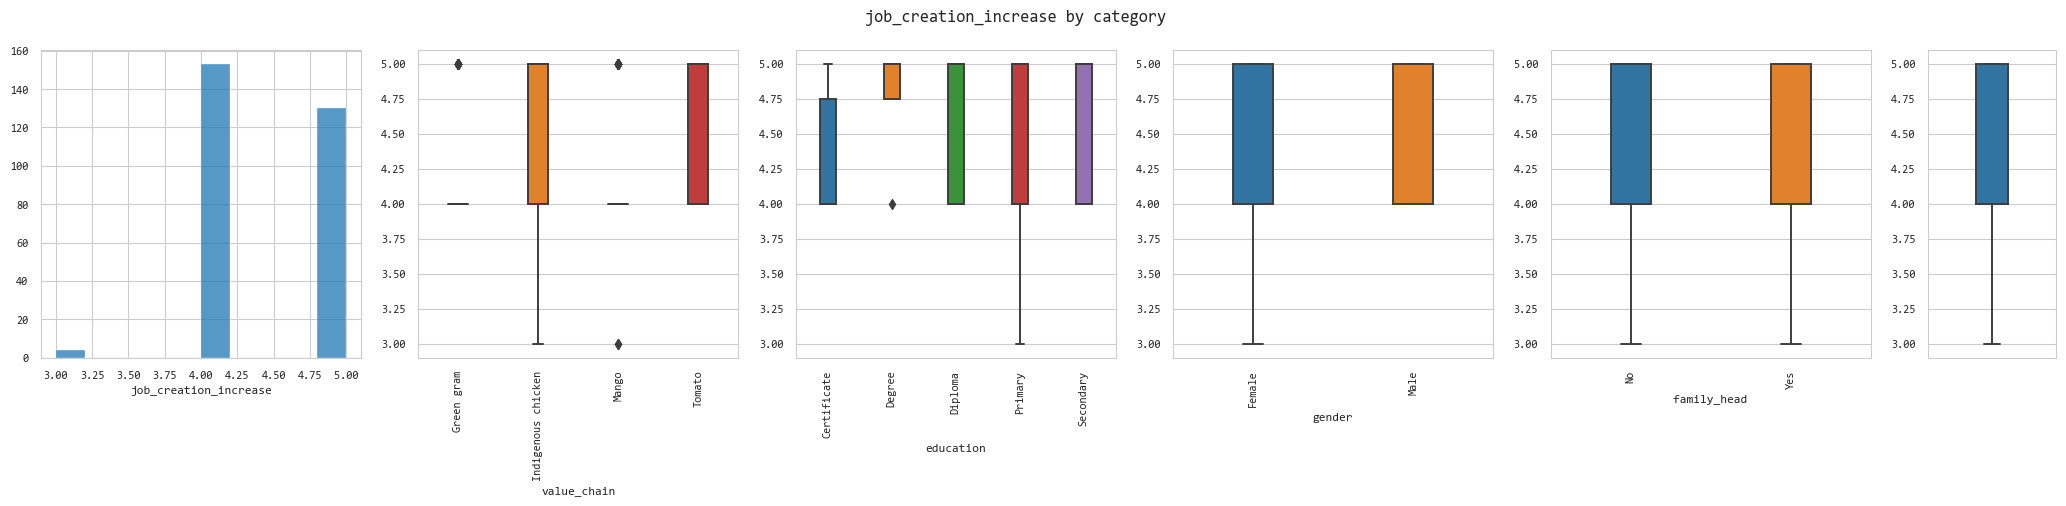

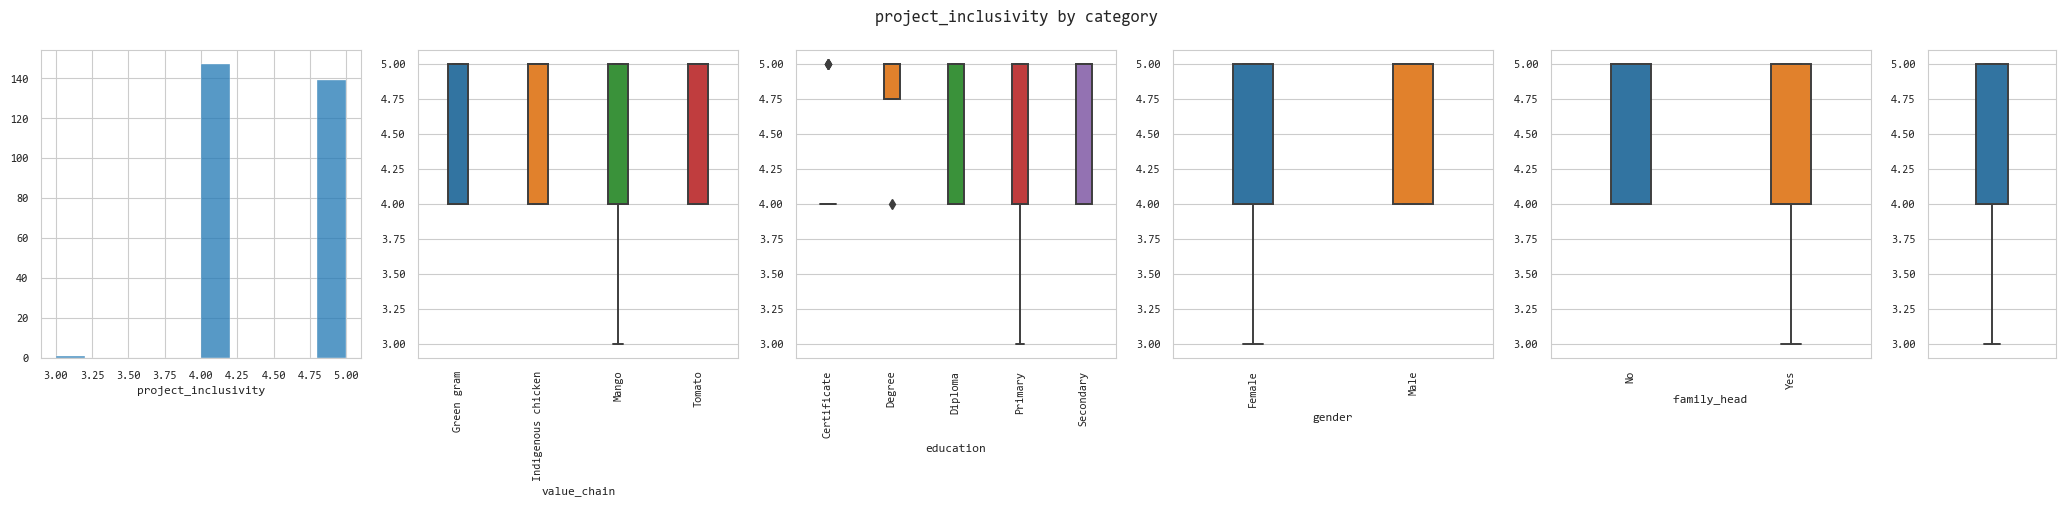

In [85]:
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'Consolas'

for col in narig_gpd.select_dtypes('number').columns:
    fig, ax = plt.subplots(1, 6, figsize=(26, 4), gridspec_kw={'width_ratios': [5, 5, 5, 5, 5, 2]})
    
    sns.histplot(x=col, data=narig_gpd, ax=ax[0])
    ax[0].set_ylabel('')
    
    for i, cat in enumerate(['value_chain', 'education', 'gender', 'family_head']):
        i += 1
        sns.boxplot(x=cat, y=col, data=narig_gpd, width=0.25, ax=ax[i])
        # sns.swarmplot(x=cat, y=col, data=narig_gpd, color='k', alpha=0.5, ax=ax[i])
        ax[i].set_ylabel('')
        ax[i].xaxis.set_tick_params(rotation=90)
        
    sns.boxplot(y=col, data=narig_gpd, width=0.25, ax=ax[5])
    # sns.swarmplot(y=col, data=narig_gpd, color='k', alpha=0.5, ax=ax[1])
    ax[5].set_ylabel('')
    
    plt.suptitle(col + ' by category')

    plt.show()

In [ ]:
# PLot the overall distribution
plt.figure(figsize=(22, 5))

# Calculate the overall distribution

In [86]:
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths=None, fontext='otf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Averia Serif Libre'

sns.scatterplot(x='price_change', y='annual_income_change', data=narig_gpd)
plt.show()

ValueError: Could not interpret value `price_change` for parameter `x`